# Importing the libraries 

In [31]:
%pip install termcolor

Note: you may need to restart the kernel to use updated packages.


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

In [33]:
import warnings

# Use the warnings filter context manager to ignore specific warnings
with warnings.catch_warnings():
    # Filter out Pandas warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'


##### Reading the data and basic understanding of data

In [34]:
df = pd.read_csv("loan.csv")
df.shape

/Users/geotech/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3526: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(39717, 111)

We have 111 columns in the beginning

In [35]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


# 1. Data Cleaning
### Step 1 - Drop Empty columns

In [36]:
empty_columns = df.columns[df.isna().sum() == len(df)].to_list()
df1 = df.drop(columns=empty_columns)
df1.shape

(39717, 57)

### Step 2 - Drop Single Valued Columns 

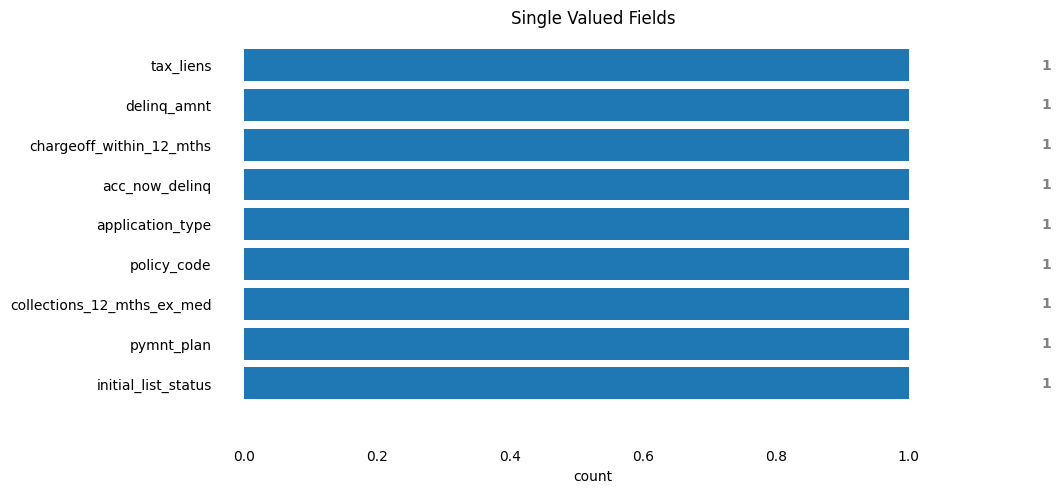

In [37]:
constant_df = df1.nunique().to_frame(name='unique_value')
constant_df = constant_df.reset_index()
constant_df = constant_df.rename(columns={'index': 'field'}).sort_values(by='unique_value', ascending=True)

# Filter just constant fields
constant_df = constant_df[constant_df['unique_value'] == 1]

# Figure Size
fig, ax = plt.subplots(figsize =(9, 5))
 
# Horizontal Bar Plot
ax.barh(constant_df["field"], constant_df["unique_value"])

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Set title
ax.set_title('Single Valued Fields')
ax.set_xlabel('count')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 20)
ax.yaxis.set_tick_params(pad = 20)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 

plt.show()

In [38]:
single_valued_cols = df1.columns[df1.nunique() == 1].to_list()
df2 = df1.drop(columns=single_valued_cols)
df2.shape

(39717, 48)

### Step 3 - Drop Unique Field

In [39]:
unique = df.columns[df.nunique() == len(df2)].to_list()
df3 = df2.drop(columns=unique)
df3.shape

(39717, 45)

### Step 4 - Drop Fields which has high number of missing values

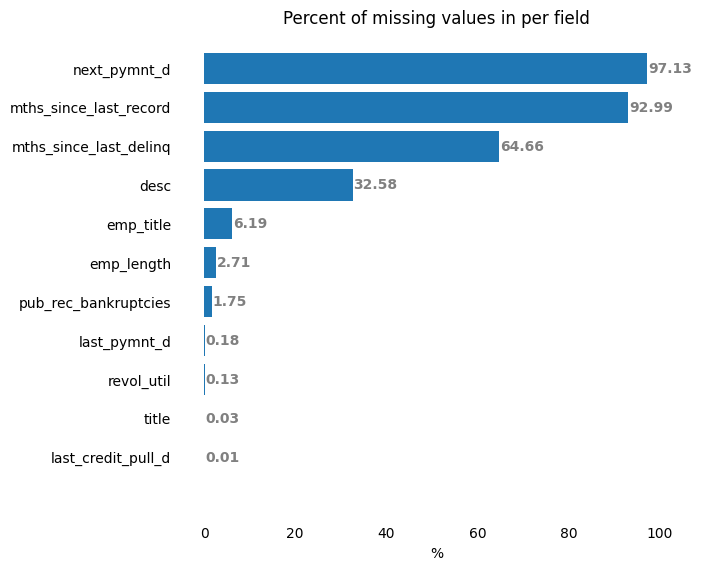

In [40]:
# We measure percentage missing value in per field and introduce a new dataframe to monitor
missing_df = df3.isnull().sum() * 100 / len(df)
missing_df.to_frame(name="percent_missing")

missing_df = missing_df.reset_index()
missing_df.columns = ['field', 'percent_missing']
missing_df = missing_df.sort_values(by="percent_missing", ascending=False)

# Filter high-percentage missing

missing_df = missing_df[missing_df['percent_missing'] > 0]
# Figure Size
fig, ax = plt.subplots(figsize =(6, 6))
 
# Horizontal Bar Plot
ax.barh(missing_df["field"], missing_df["percent_missing"])

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Set title
ax.set_title('Percent of missing values in per field')
ax.set_xlabel('%')


# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 20)
ax.yaxis.set_tick_params(pad = 20)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 

plt.show()

##### We are dropping fields which have more than 90% missing values
- mths_since_last_record
- next_pymnt_d


In [41]:
high_missing_fields = df3.columns[round(df3.isna().sum()*100/len(df2), 0) > 90]
df4 = df3.drop(columns=high_missing_fields)
df4.shape

(39717, 43)

In [42]:
high_missing_fields

Index(['mths_since_last_record', 'next_pymnt_d'], dtype='object')

### Step 5 - Drop Fields which has most of the numbers at 0 and remaning are outliers
Dropping the follwing fields
- delinq_2yrs
- pub_rec
- out_prncp
- out_prncp_inv

In [43]:
dropping_fields = ['delinq_2yrs', 'pub_rec', 'out_prncp', 'out_prncp_inv']
df5 = df4.drop(columns=dropping_fields)
df5.shape

(39717, 39)

### Step 6 - Drop Unnecessary fields which wont help in analysis
- emp_title
- desc
- title
- zip_code
- mths_since_last_delinq
- total_pymnt
- total_pymnt_inv
- total_rec_int
- total_rec_late_fee
- recoveries
- collection_recovery_fee
- last_pymnt_d
- last_pymnt_amnt
- pub_rec_bankruptcies


In [44]:
unnecessary_fields = ['emp_title', 'desc', 'title', 'zip_code', 'mths_since_last_delinq', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'pub_rec_bankruptcies']
df6 = df5.drop(columns=unnecessary_fields)
df6.shape

(39717, 25)

### Convert Datatypes of fields

In [45]:
# We set expected datatype for each fields as the baseline for data formating
expected_data_types = [{'field': 'loan_amnt', 'expected_type': 'int64'}, {'field': 'funded_amnt', 'expected_type': 'int64'}, {'field': 'funded_amnt_inv', 'expected_type': 'float64'}, {'field': 'term', 'expected_type': 'object'}, {'field': 'int_rate', 'expected_type': 'float64'}, {'field': 'installment', 'expected_type': 'float64'}, {'field': 'grade', 'expected_type': 'object'}, {'field': 'sub_grade', 'expected_type': 'object'}, {'field': 'emp_title', 'expected_type': 'object'}, {'field': 'emp_length', 'expected_type': 'object'}, {'field': 'home_ownership', 'expected_type': 'object'}, {'field': 'annual_inc', 'expected_type': 'float64'}, {'field': 'verification_status', 'expected_type': 'object'}, {'field': 'issue_d', 'expected_type': 'datetime64[ns]'}, {'field': 'loan_status', 'expected_type': 'object'}, {'field': 'desc', 'expected_type': 'object'}, {'field': 'purpose', 'expected_type': 'object'}, {'field': 'title', 'expected_type': 'object'}, {'field': 'zip_code', 'expected_type': 'object'}, {'field': 'addr_state', 'expected_type': 'object'}, {'field': 'dti', 'expected_type': 'float64'}, {'field': 'delinq_2yrs', 'expected_type': 'int64'}, {'field': 'earliest_cr_line', 'expected_type': 'datetime64[ns]'}, {'field': 'inq_last_6mths', 'expected_type': 'int64'}, {'field': 'mths_since_last_delinq', 'expected_type': 'float64'}, {'field': 'mths_since_last_record', 'expected_type': 'float64'}, {'field': 'open_acc', 'expected_type': 'int64'}, {'field': 'pub_rec', 'expected_type': 'int64'}, {'field': 'revol_bal', 'expected_type': 'int64'}, {'field': 'revol_util', 'expected_type': 'float64'}, {'field': 'total_acc', 'expected_type': 'int64'}, {'field': 'out_prncp', 'expected_type': 'float64'}, {'field': 'out_prncp_inv', 'expected_type': 'float64'}, {'field': 'total_pymnt', 'expected_type': 'float64'}, {'field': 'total_pymnt_inv', 'expected_type': 'float64'}, {'field': 'total_rec_prncp', 'expected_type': 'float64'}, {'field': 'total_rec_int', 'expected_type': 'float64'}, {'field': 'total_rec_late_fee', 'expected_type': 'float64'}, {'field': 'recoveries', 'expected_type': 'float64'}, {'field': 'collection_recovery_fee', 'expected_type': 'float64'}, {'field': 'last_pymnt_d', 'expected_type': 'datetime64[ns]'}, {'field': 'last_pymnt_amnt', 'expected_type': 'float64'}, {'field': 'next_pymnt_d', 'expected_type': 'datetime64[ns]'}, {'field': 'last_credit_pull_d', 'expected_type': 'datetime64[ns]'}, {'field': 'pub_rec_bankruptcies', 'expected_type': 'float64'}]
expected_type_df = pd.DataFrame(expected_data_types)
expected_type_df.head()

,field,expected_type
0,loan_amnt,int64
1,funded_amnt,int64
2,funded_amnt_inv,float64
3,term,object
4,int_rate,float64


In [46]:
def load_type_df(df: pd.DataFrame, filter_type: str = None) -> pd.DataFrame:
    """
        Function help to filter fields by a specific datatype
    """
    default_type_df = df.dtypes.to_frame(name='default_type')
    default_type_df = default_type_df.reset_index()

    if filter_type:
        default_type_df = default_type_df[default_type_df['default_type'] == filter_type]

    return default_type_df.rename(columns={'index': 'field'})


def assert_datatypes(df: pd.DataFrame, expected_df: pd.DataFrame) -> pd.DataFrame:
    """

    """

    default_type_df = load_type_df(df)
    
    types_df = pd.merge(default_type_df, expected_df, how='left', on='field')
    return types_df[types_df['default_type'] != types_df['expected_type']]

# Check fields need to convert datatype
df6_dtypes = assert_datatypes(df6, expected_type_df)
df6_dtypes

,field,default_type,expected_type
4,int_rate,object,float64
12,issue_d,object,datetime64[ns]
17,earliest_cr_line,object,datetime64[ns]
21,revol_util,object,float64
24,last_credit_pull_d,object,datetime64[ns]


In [47]:
df7 = df6.copy()

df7['int_rate'] = df6['int_rate'].apply(lambda x: float(x[:-1]) if isinstance(x, str) else float(x))
df7['revol_util'] = df6['revol_util'].apply(lambda x: float(x[:-1]) if isinstance(x, str) else float(x))
df7['issue_d'] = df6['issue_d'].apply(lambda x: pd.to_datetime(x, format='%b-%y'))
df7['earliest_cr_line'] = df6['earliest_cr_line'].apply(lambda x: pd.to_datetime(x, format='%b-%y'))
df7['last_credit_pull_d'] = df6['last_credit_pull_d'].apply(lambda x: pd.to_datetime(x, format='%b-%y'))


# Make sure all fields are converted to correct datatypes
assert len(assert_datatypes(df7, expected_type_df)) == 0

### Business Driven Metrics
---
- We are adding 2 more fields(both have same meaning) based on 'loan_status' field.  
- If the 'loan_status' is 'Charged Off', then we are labelling 'is_default' as 'YES' otherwise 'NO'.  
- If the 'loan_status' is 'Charged Off', then we are labelling 'default_status' as '1' otherwise '0'.  

In [48]:
df_final = df7.copy()
df_final['is_default'] = df7['loan_status'].apply(lambda x: 'YES' if x == 'Charged Off' else 'NO')
df_final['default_status'] = df7['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
df_final.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,earliest_cr_line,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,total_rec_prncp,last_credit_pull_d,is_default,default_status
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,1985-01-01,1,3,13648,83.7,9,5000.00,2016-05-01,NO,0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,1999-04-01,5,3,1687,9.4,4,456.46,2013-09-01,YES,1
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,2001-11-01,2,2,2956,98.5,10,2400.00,2016-05-01,NO,0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,1996-02-01,1,10,5598,21.0,37,10000.00,2016-04-01,NO,0
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,1996-01-01,0,15,27783,53.9,38,2475.94,2016-05-01,NO,0


# 2. Bucketizing the fields into Categorical and Numeric variables 

## Categorical Fields

### Unordered Categorical Variables
- term - 36 or 60 months
- grade - LC assigned loan grade
- sub_grade - it is sub-division of grade
- home_ownership - home ownership status RENT, OWN, MORTGAGE, OTHER.
- verification_status - Indicates if income was verified by LC, not verified, or if the income source was verified
- loan_status
- purpose
- addr_state

### Ordered Categorical Variables
- emp_length - Employment length in years
- inq_last_6mths - The number of inquiries in past 6 months


## Quantitative Fields
- loan_amnt
- funded_amnt
- funded_amnt_inv - This is almost same as 'funded_amnt' field
- int_rate
- installment
- annual_inc
- dti 
- total_rec_prncp- Principal received to date

- revol_bal
- revol_util 

- total_acc
- open_acc


## Date Fileds
- issue_d
- earliest_cr_line
- last_credit_pull_d 


# 3. Univariate Analysis 
---
## A. Unordered Categorical Variables/Fields

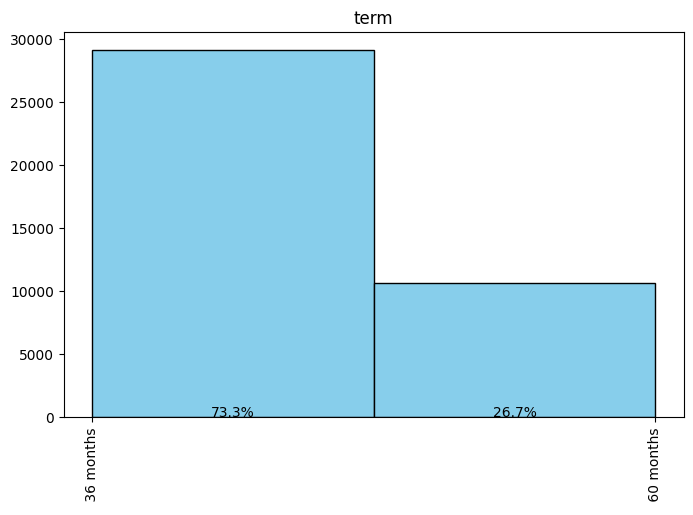

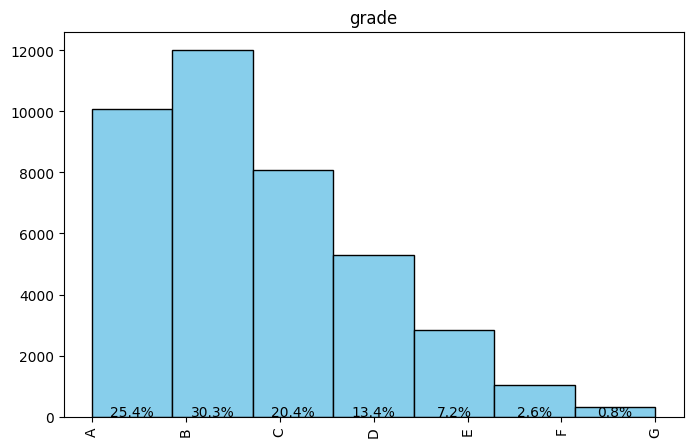

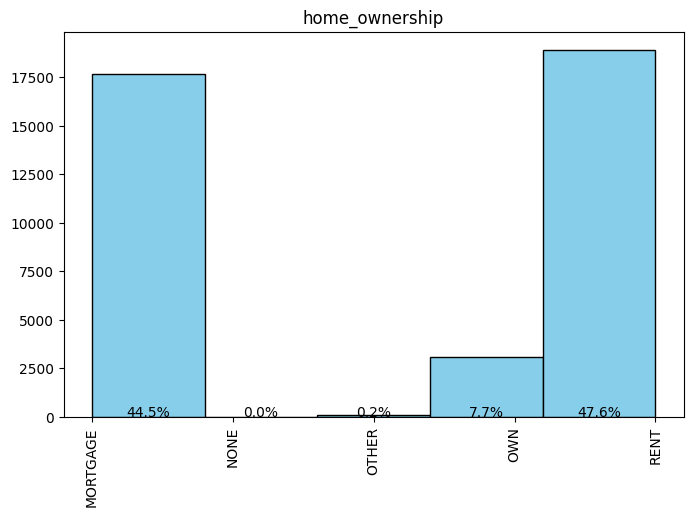

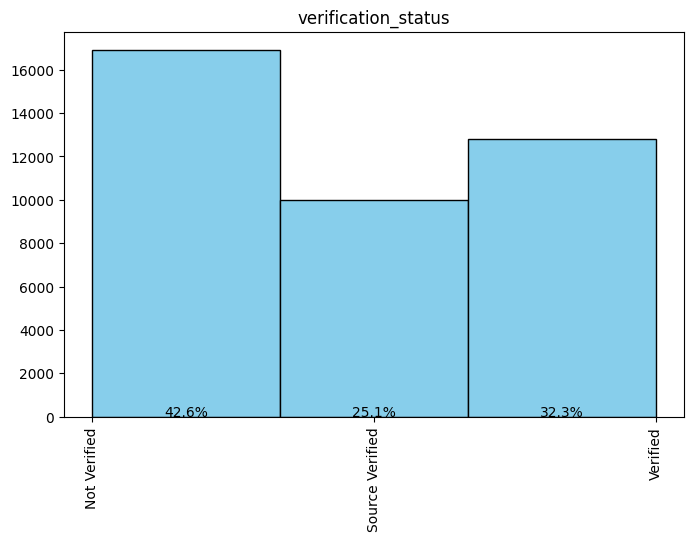

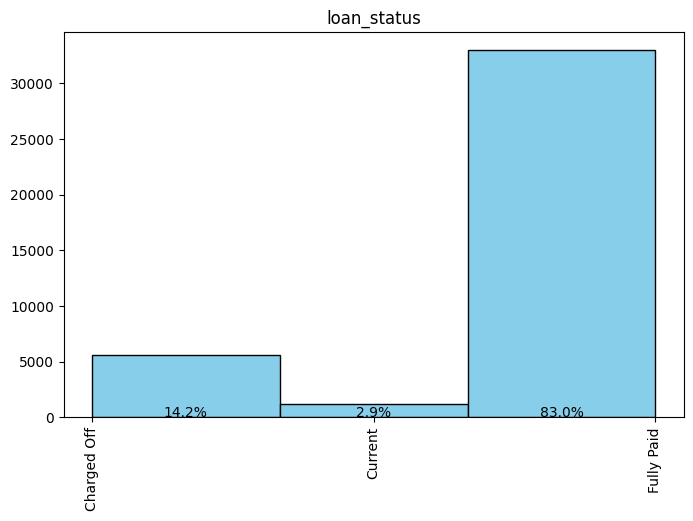

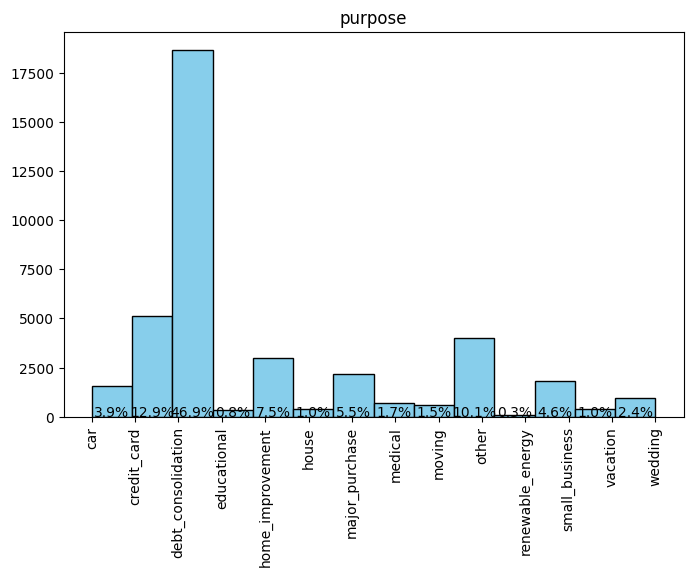

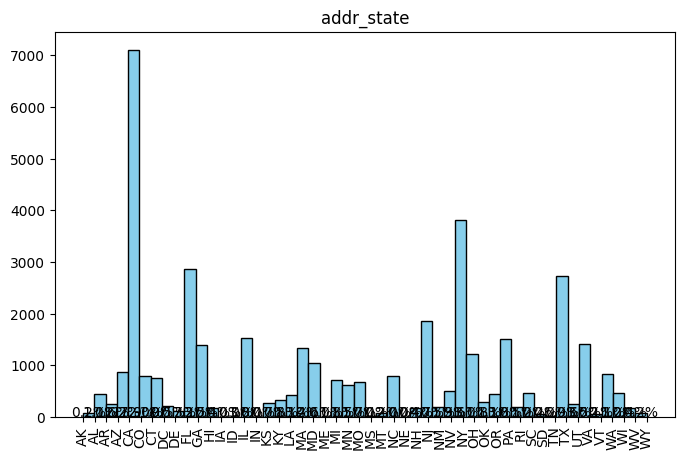

In [49]:
unordered_categorical = ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state']

for field in unordered_categorical:
    item_count = df_final[field].nunique()
    plt.figure(figsize=(8,5),facecolor='white',edgecolor='blue')

    dataset = df_final[field].sort_values()
    n, bins, patches = plt.hist(dataset, bins=item_count, color='skyblue', edgecolor='black')

    plt.title(field)
    plt.xticks(rotation = 90)
    
    # Calculate the percentage for each bin
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_counts = n.astype(int)  # Convert counts to integers

    # Annotate each bar with its percentage value
    for count, x in zip(bin_counts, bin_centers):
        percentage = f'{(count / len(df_final[field])) * 100:.1f}%'
        plt.annotate(percentage, (x, 0.02), ha='center')

    plt.show()

<span style="color:green">Inferences - Unordered Univariate Analysis :  </span>

- Term = Most of the loans (73%) have 36 months tenure where as only 26% loans have 60 months tenure.
- Grade = Most common loan grades are B(30%), A(25%) and C(20%)  
- home_ownership, purpose = Most of the borrowers dont have their own house. 92% borrowers either pay "Rent" or "Mortgage" their house. But only 1% borrowers''purpose' of the loan is 'house'. And 47% borrowers' purpose is 'debt_consolidation'.  
- verification_status = 42% of the borrowers' income is 'not verified' which is risky.  
- loan_status = Only 14% of the borrowers are 'Defaulters'  



============ % of defaulted loans for different TERM ============



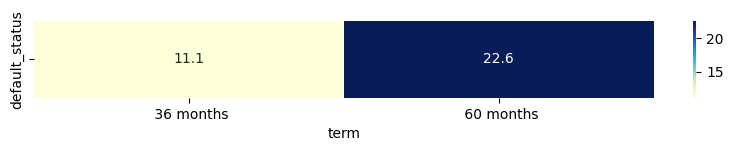


============ % of defaulted loans for different GRADE ============



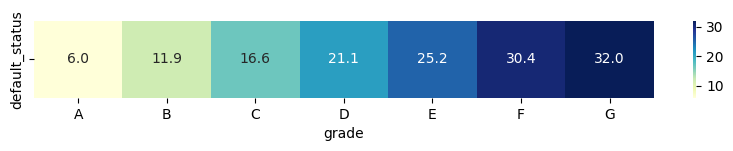


============ % of defaulted loans for different EMP_LENGTH ============



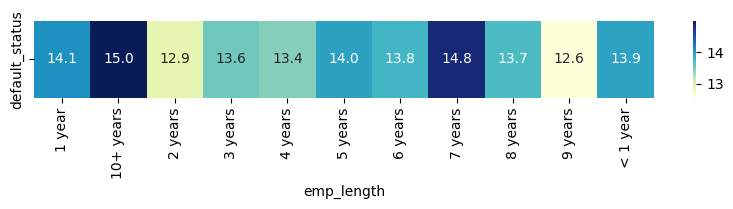


============ % of defaulted loans for different HOME_OWNERSHIP ============



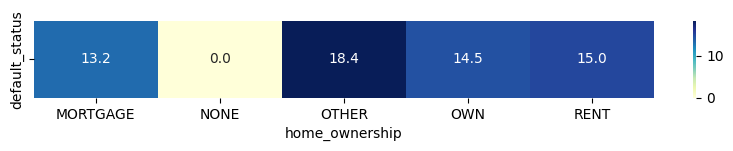


============ % of defaulted loans for different VERIFICATION_STATUS ============



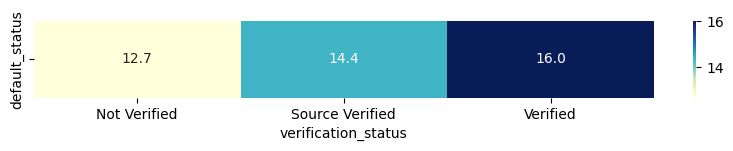


============ % of defaulted loans for different PURPOSE ============



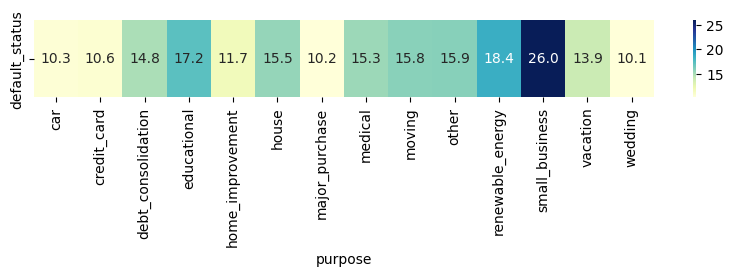


============ % of defaulted loans for different ADDR_STATE ============



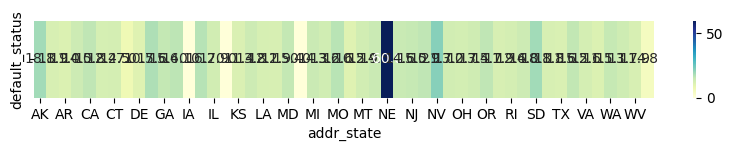


============ % of defaulted loans for different INQ_LAST_6MTHS ============



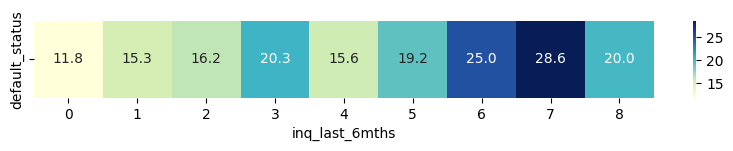

In [50]:
fields = ['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'inq_last_6mths']

for field in fields:
    t = pd.pivot_table(
        df_final, 
        columns=field, 
        values='default_status', 
        aggfunc='mean',
        ).apply(lambda x: x * 100)

    if len(t) == 0:
        continue

    print(f"\n============ % of defaulted loans for different {field.upper()} ============\n")

    plt.figure(figsize=(10, 1))
    sns.heatmap(t, cmap='YlGnBu',annot=True, fmt='0.1f')
    plt.show()


<span style="color:green">Inferences - Univarite or Bivariate Analysis on Categorical Variables: </span>
- Term - Loans with 60 months tenure have double chances (22.6%) of getting default than loans with 36 months tenure (11.1%)
  
- Grade - G grade loans have highest chance of getting default (32%). Where as A grade loans have less chances of getting default(only 6%).
  
- emp_length - There is a 15% chance of loan getting default when employment length of the borrower is 10+ years.  
  
- Home_ownership - Most of the loan borrowers dont have their own house. Their home is either Rented or Mortgaged. There is almost 13 to 15 % chance of these borrowers getting defaulted.   

- Verification Status - For Non - Verified Loan, 12% chance is there for getting defaulted.

- Purpose - Loans with small business purpose have highest chances (26%) of getting defaulted. Whereas loans for wedding, car or major purchase have lowest chances (only 10%) of getting defaulted.

- Address State - NE state has very high loan defaulting status (60%).

- inq_last_6months - Higher number of inquiries is indication of high chances of defaulted loan. 

## B. Ordered Categorical Variables

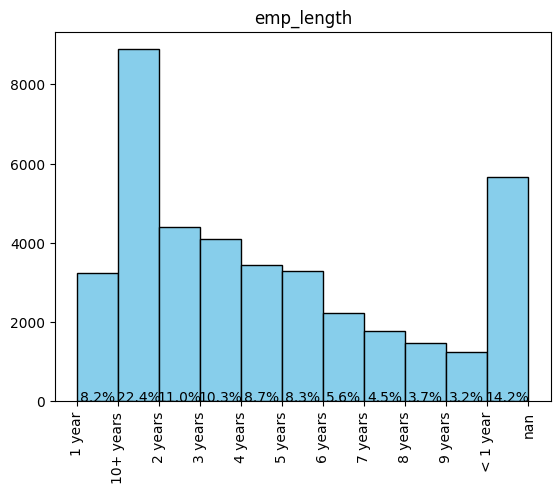

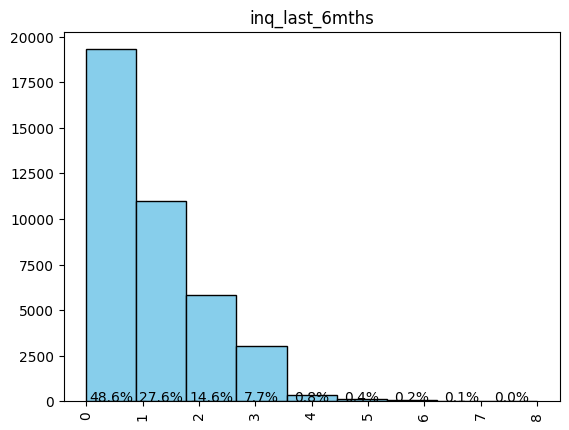

In [51]:
ordered_categorical = ['emp_length', 'inq_last_6mths']


for field in ordered_categorical:
    item_count = df_final[field].nunique()
    dataset = df_final[field].sort_values().astype(str).dropna()
    n, bins, patches = plt.hist(dataset, bins=item_count,color='skyblue', edgecolor='black')
    
    plt.title(field)
    plt.xticks(rotation = 90)
    
    # Calculate the percentage for each bin
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_counts = n.astype(int)  # Convert counts to integers

    # Annotate each bar with its percentage value
    for count, x in zip(bin_counts, bin_centers):
        percentage = f'{(count / len(df_final[field])) * 100:.1f}%'
        plt.annotate(percentage, (x, 0.02), ha='center')
    
    plt.show()

<span style="color:green">Inferences - Ordered Univariate Analysis:  </span>
- emp_length = Most of the borrowers (22.4%) have  10+ years of employment length.
   
- inq_last_6mths = Half of the times (48%) there is no inquiry or 0 inqury in last 6 months

## C. Quantitative Variable Analysis
___

loan_amnt


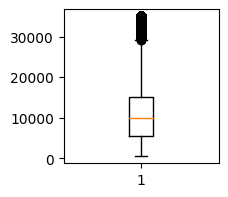

count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64
**************************************************
funded_amnt


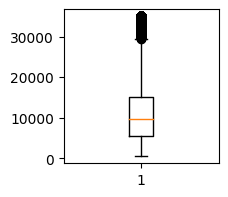

count    39717.000000
mean     10947.713196
std       7187.238670
min        500.000000
25%       5400.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64
**************************************************
funded_amnt_inv


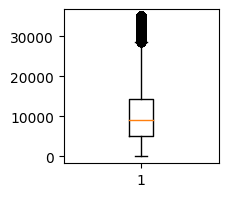

count    39717.000000
mean     10397.448868
std       7128.450439
min          0.000000
25%       5000.000000
50%       8975.000000
75%      14400.000000
max      35000.000000
Name: funded_amnt_inv, dtype: float64
**************************************************
int_rate


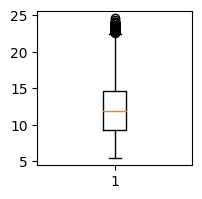

count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64
**************************************************
installment


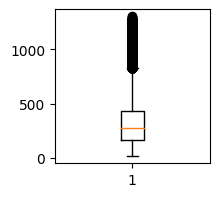

count    39717.000000
mean       324.561922
std        208.874874
min         15.690000
25%        167.020000
50%        280.220000
75%        430.780000
max       1305.190000
Name: installment, dtype: float64
**************************************************
annual_inc


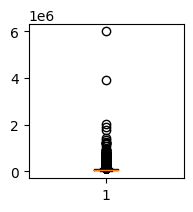

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64
**************************************************
dti


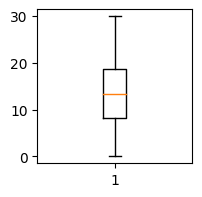

count    39717.000000
mean        13.315130
std          6.678594
min          0.000000
25%          8.170000
50%         13.400000
75%         18.600000
max         29.990000
Name: dti, dtype: float64
**************************************************
total_rec_prncp


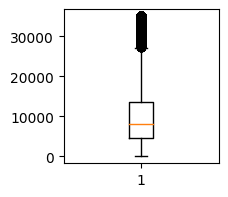

count    39717.000000
mean      9793.348813
std       7065.522127
min          0.000000
25%       4600.000000
50%       8000.000000
75%      13653.260000
max      35000.020000
Name: total_rec_prncp, dtype: float64
**************************************************
revol_bal


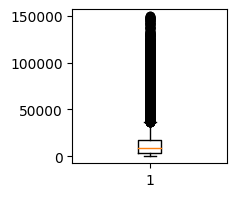

count     39717.000000
mean      13382.528086
std       15885.016641
min           0.000000
25%        3703.000000
50%        8850.000000
75%       17058.000000
max      149588.000000
Name: revol_bal, dtype: float64
**************************************************
revol_util


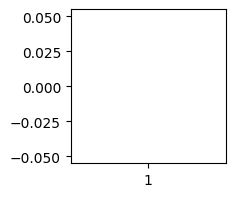

count    39667.000000
mean        48.832152
std         28.332634
min          0.000000
25%         25.400000
50%         49.300000
75%         72.400000
max         99.900000
Name: revol_util, dtype: float64
**************************************************
total_acc


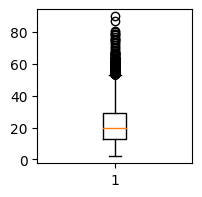

count    39717.000000
mean        22.088828
std         11.401709
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64
**************************************************
open_acc


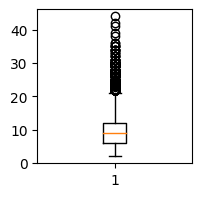

count    39717.000000
mean         9.294408
std          4.400282
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64
**************************************************


In [52]:
quantitative_fields = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'total_rec_prncp', 'revol_bal', 'revol_util', 'total_acc', 'open_acc']

for field in quantitative_fields:
    print(colored(field, 'red'))
    plt.figure(figsize=(2,2))
    plt.boxplot(df_final[field])
    plt.show()
    print(df_final[field].describe())
    print("*" * 50)


# 4. Segmented Univariate Analysis
___

field =  loan_amnt     Category =  term 



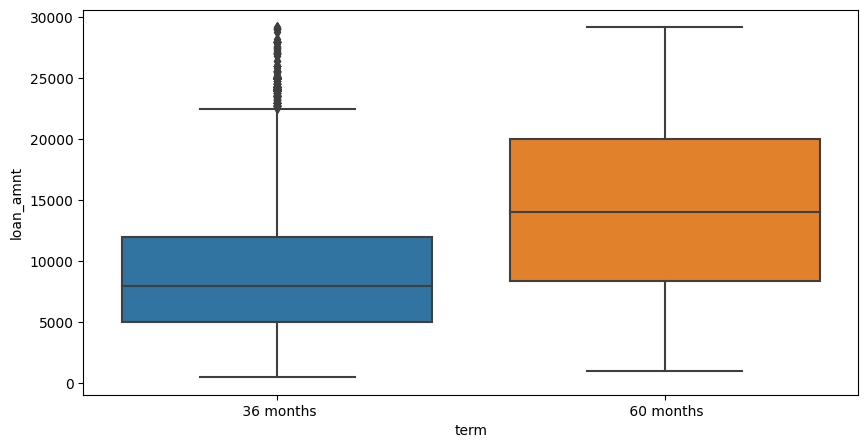

               loan_amnt                                              
                    mean   min    max <lambda_0> <lambda_1> <lambda_2>
term                                                                  
 36 months   9592.936314   500  35000     5000.0     8000.0    12250.0
 60 months  15675.225967  1000  35000     9250.0    15000.0    20500.0
--------------------------------------------------------------------------------
field =  loan_amnt     Category =  grade 



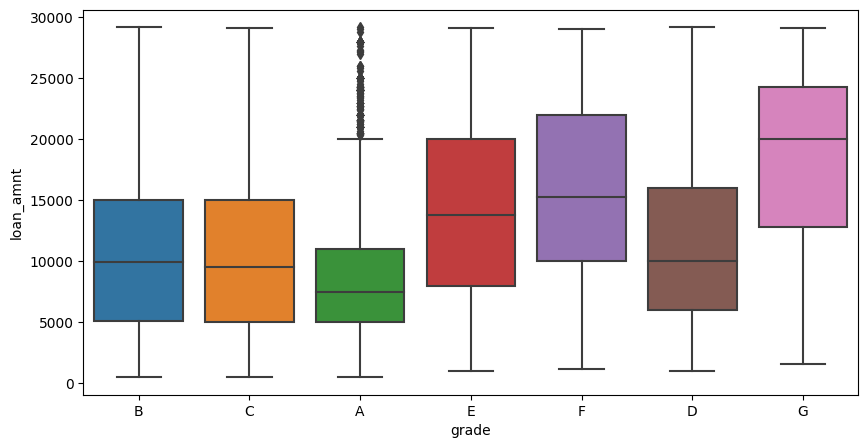

          loan_amnt                                              
               mean   min    max <lambda_0> <lambda_1> <lambda_2>
grade                                                            
A       8624.928111   500  35000    5000.00     7500.0    11200.0
B      11119.080699   500  35000    5375.00    10000.0    15000.0
C      11004.670906   500  35000    5000.00     9725.0    15000.0
D      12278.198606  1000  35000    6000.00    10000.0    16000.0
E      15847.255454  1000  35000    8400.00    15000.0    22000.0
F      18363.298379  1200  35000   10800.00    18000.0    25000.0
G      20226.819620  1600  35000   14056.25    20250.0    25000.0
--------------------------------------------------------------------------------
field =  loan_amnt     Category =  home_ownership 



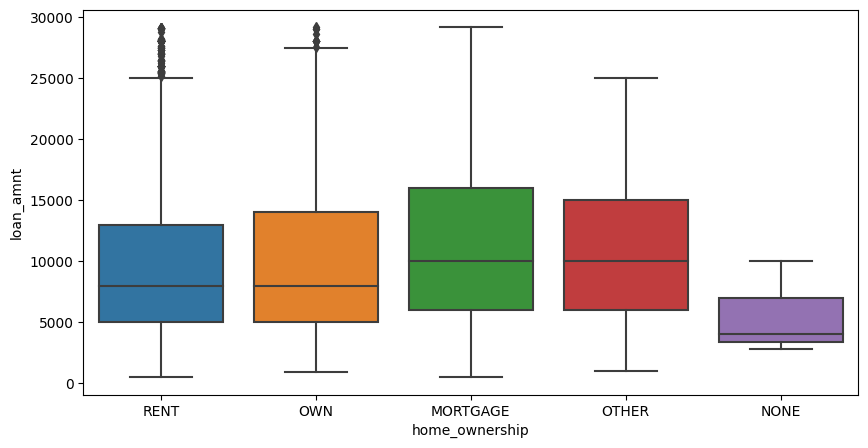

                   loan_amnt                                              
                        mean   min    max <lambda_0> <lambda_1> <lambda_2>
home_ownership                                                            
MORTGAGE        12690.073051   500  35000     6000.0    10800.0    17500.0
NONE             5600.000000  2800  10000     3400.0     4000.0     7000.0
OTHER           10663.010204  1000  25000     6000.0    10000.0    15000.0
OWN             10256.752780   900  35000     5000.0     8312.5    14125.0
RENT            10004.853431   500  35000     5000.0     8400.0    13475.0
--------------------------------------------------------------------------------
field =  loan_amnt     Category =  verification_status 



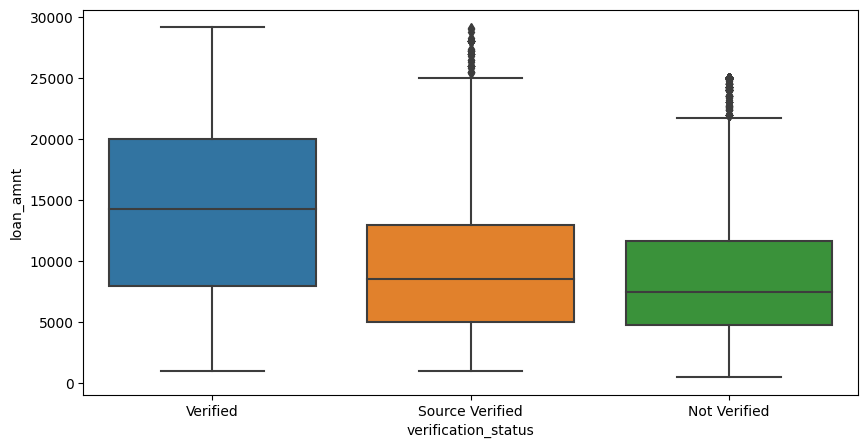

                        loan_amnt                                     \
                             mean   min    max <lambda_0> <lambda_1>   
verification_status                                                    
Not Verified          8421.431948   500  35000     4800.0     7500.0   
Source Verified      10099.829779  1000  35000     5000.0     9000.0   
Verified             15788.632992  1000  35000     9000.0    15000.0   

                                
                    <lambda_2>  
verification_status             
Not Verified           11750.0  
Source Verified        14000.0  
Verified               21650.0  
--------------------------------------------------------------------------------
field =  loan_amnt     Category =  purpose 



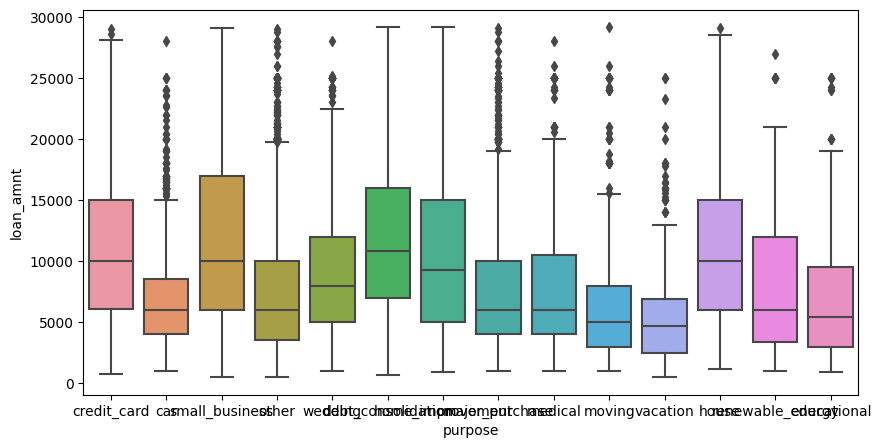

                       loan_amnt                                              
                            mean   min    max <lambda_0> <lambda_1> <lambda_2>
purpose                                                                       
car                  6777.517753  1000  32000     4000.0     6000.0     8500.0
credit_card         11723.615984   725  35000     6400.0    10000.0    15000.0
debt_consolidation  12694.989539   700  35000     7000.0    11500.0    16800.0
educational          6810.461538   900  25000     3000.0     5400.0     9500.0
home_improvement    11537.205981   900  35000     5000.0    10000.0    15000.0
house               13070.997375  1200  35000     6000.0    11000.0    17175.0
major_purchase       8155.429813  1000  35000     4000.0     6000.0    10000.0
medical              8263.672439  1000  35000     4000.0     6000.0    10800.0
moving               6650.171527  1000  35000     3000.0     5000.0     8000.0
other                8067.612071   500  35000     35

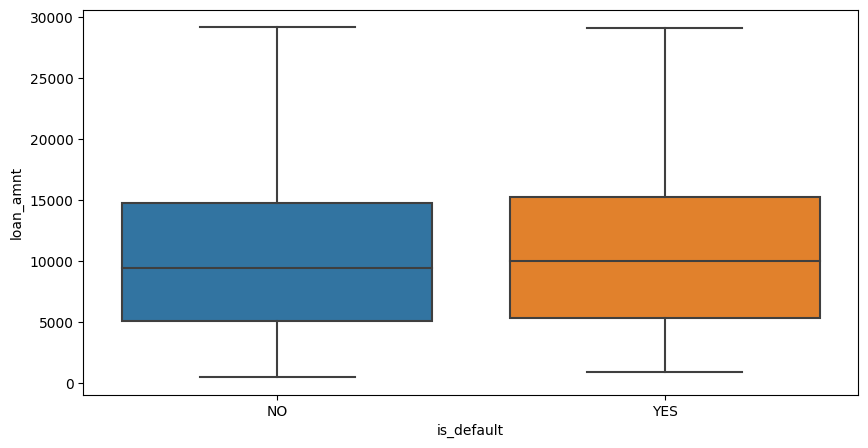

               loan_amnt                                             
                    mean  min    max <lambda_0> <lambda_1> <lambda_2>
is_default                                                           
NO          11073.372690  500  35000     5450.0     9800.0    15000.0
YES         12104.385108  900  35000     5600.0    10000.0    16500.0
--------------------------------------------------------------------------------
field =  int_rate     Category =  term 



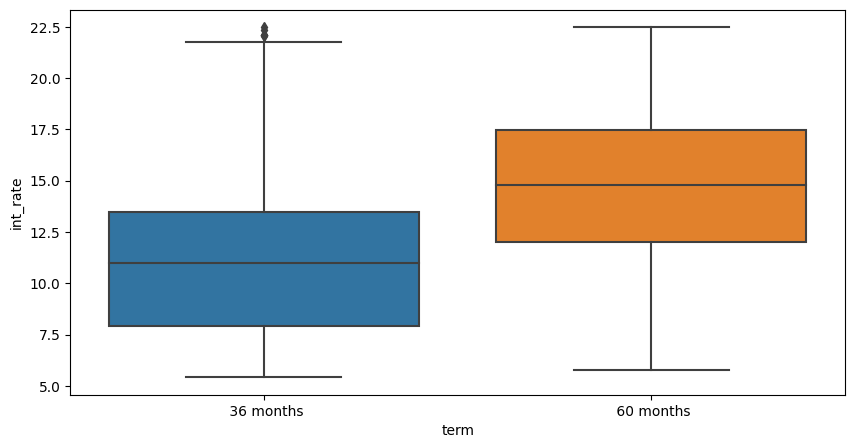

             int_rate                                              
                 mean   min    max <lambda_0> <lambda_1> <lambda_2>
term                                                               
 36 months  11.004656  5.42  23.22       7.90      10.99      13.47
 60 months  14.805912  5.79  24.59      11.99      14.83      17.49
--------------------------------------------------------------------------------
field =  int_rate     Category =  grade 



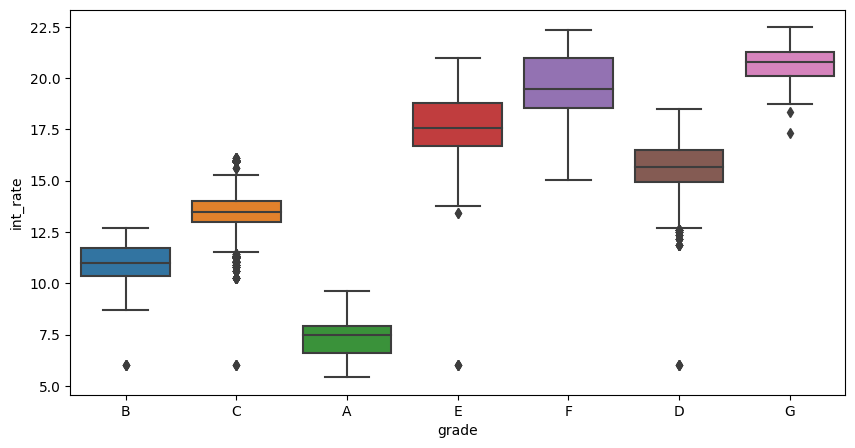

        int_rate                                               
            mean    min    max <lambda_0> <lambda_1> <lambda_2>
grade                                                          
A       7.335262   5.42   9.63     6.6200       7.49       7.90
B      11.021224   6.00  12.69    10.3700      10.99      11.71
C      13.552960   6.00  16.11    12.9900      13.49      13.99
D      15.719900   6.00  18.49    14.9600      15.65      16.49
E      17.711714   6.00  20.99    16.6925      17.56      18.79
F      19.749323  15.01  22.94    18.5400      19.47      20.99
G      21.401044  17.34  24.59    20.4000      21.14      22.48
--------------------------------------------------------------------------------
field =  int_rate     Category =  home_ownership 



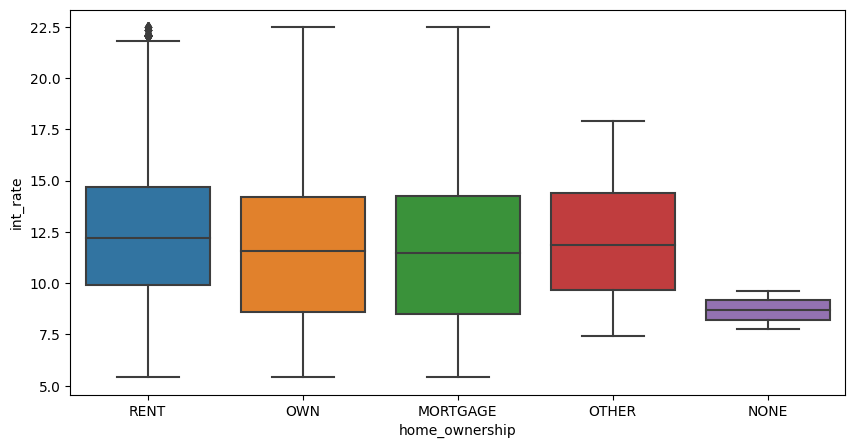

                 int_rate                                              
                     mean   min    max <lambda_0> <lambda_1> <lambda_2>
home_ownership                                                         
MORTGAGE        11.771737  5.42  24.59     8.4900      11.49      14.27
NONE             8.696667  7.75   9.64     8.2250       8.70       9.17
OTHER           12.040918  7.40  17.90     9.6475      11.86      14.38
OWN             11.772642  5.42  23.59     8.5900      11.58      14.22
RENT            12.294890  5.42  24.40     9.9100      12.21      14.72
--------------------------------------------------------------------------------
field =  int_rate     Category =  verification_status 



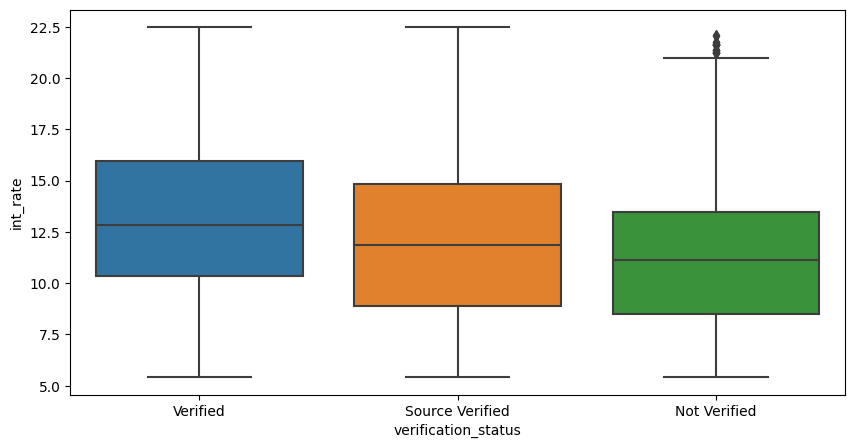

                      int_rate                                              
                          mean   min    max <lambda_0> <lambda_1> <lambda_2>
verification_status                                                         
Not Verified         11.203965  5.42  24.40       8.49      11.12      13.49
Source Verified      12.106929  5.42  23.91       8.90      11.86      14.91
Verified             13.033872  5.42  24.59      10.37      12.87      15.96
--------------------------------------------------------------------------------
field =  int_rate     Category =  purpose 



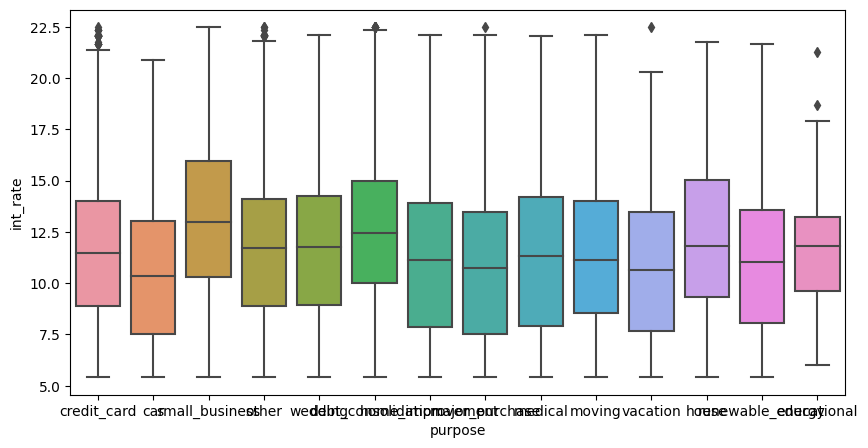

                     int_rate                                              
                         mean   min    max <lambda_0> <lambda_1> <lambda_2>
purpose                                                                    
car                 10.530097  5.42  22.85      7.510      10.37     13.060
credit_card         11.701173  5.42  24.11      8.900      11.49     13.980
debt_consolidation  12.487890  5.42  24.11      9.990      12.42     15.050
educational         11.650831  6.00  21.27      9.630      11.83     13.220
home_improvement    11.400265  5.42  23.91      7.880      11.12     13.920
house               12.228136  5.42  23.13      9.320      11.83     15.050
major_purchase      10.843064  5.42  23.59      7.510      10.74     13.490
medical             11.492121  5.42  22.06      7.910      11.34     14.220
moving              11.563619  5.42  22.11      8.540      11.14     13.990
other               11.815111  5.42  24.59      8.900      11.71     14.110
renewable_en

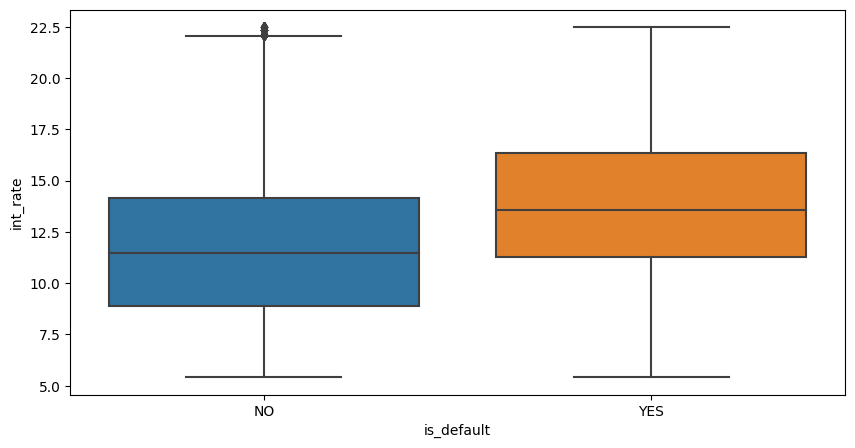

             int_rate                                              
                 mean   min    max <lambda_0> <lambda_1> <lambda_2>
is_default                                                         
NO          11.724186  5.42  24.59       8.88      11.49      14.17
YES         13.820432  5.42  24.40      11.31      13.61      16.40
--------------------------------------------------------------------------------
field =  total_rec_prncp     Category =  term 



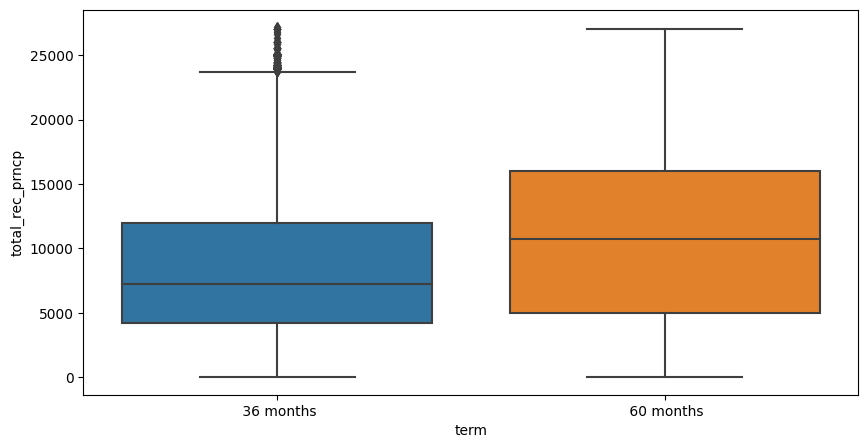

           total_rec_prncp                                                
                      mean  min       max <lambda_0> <lambda_1> <lambda_2>
term                                                                      
 36 months     8847.205155  0.0  35000.00     4250.0    7500.00    12000.0
 60 months    12385.288920  0.0  35000.02     5500.0   11682.06    17600.0
--------------------------------------------------------------------------------
field =  total_rec_prncp     Category =  grade 



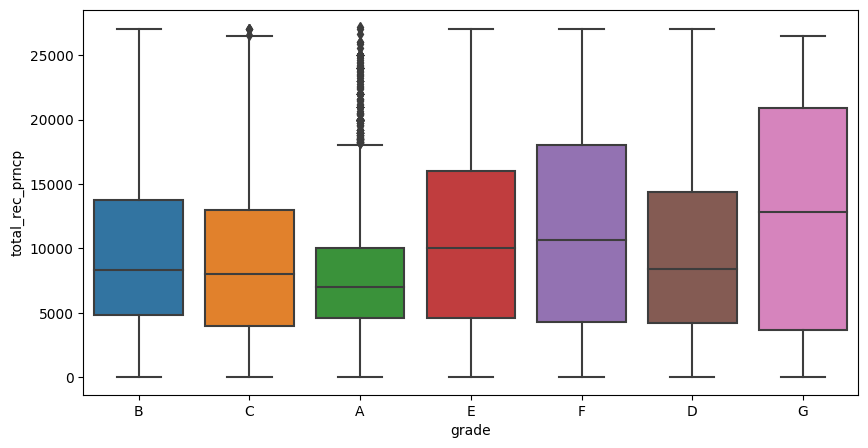

      total_rec_prncp                                                 
                 mean  min       max <lambda_0> <lambda_1>  <lambda_2>
grade                                                                 
A         8144.953967  0.0  35000.00  4739.6500    7000.00  10200.0000
B        10043.959324  0.0  35000.00  4800.0000    8500.00  14081.2500
C         9546.577267  0.0  35000.02  4000.0000    8000.00  14000.0000
D        10301.583657  0.0  35000.02  4400.0000    8875.00  15000.0000
E        12418.440781  0.0  35000.00  5000.0000   11100.25  18000.0000
F        13403.096416  0.0  35000.01  4801.5400   12021.24  20000.0000
G        15064.680222  0.0  35000.00  4692.4525   15000.00  24943.7475
--------------------------------------------------------------------------------
field =  total_rec_prncp     Category =  home_ownership 



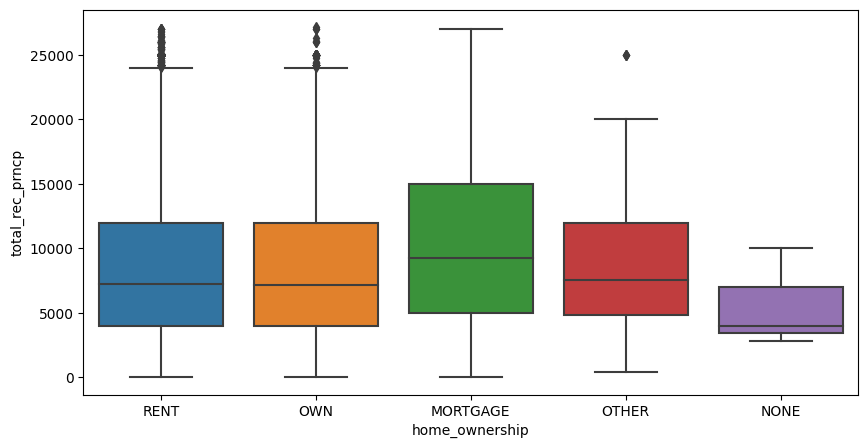

               total_rec_prncp                                           \
                          mean      min       max <lambda_0> <lambda_1>   
home_ownership                                                            
MORTGAGE          11060.718137     0.00  35000.00     5000.0   9850.000   
NONE               5599.996667  2800.00   9999.99     3400.0   4000.000   
OTHER              8654.554592   413.62  25000.00     4800.0   7499.995   
OWN                8957.181432     0.00  35000.00     4000.0   7312.500   
RENT               8751.003020     0.00  35000.02     4000.0   7200.000   

                           
               <lambda_2>  
home_ownership             
MORTGAGE        15000.000  
NONE             6999.995  
OTHER           12000.000  
OWN             12000.000  
RENT            12000.000  
--------------------------------------------------------------------------------
field =  total_rec_prncp     Category =  verification_status 



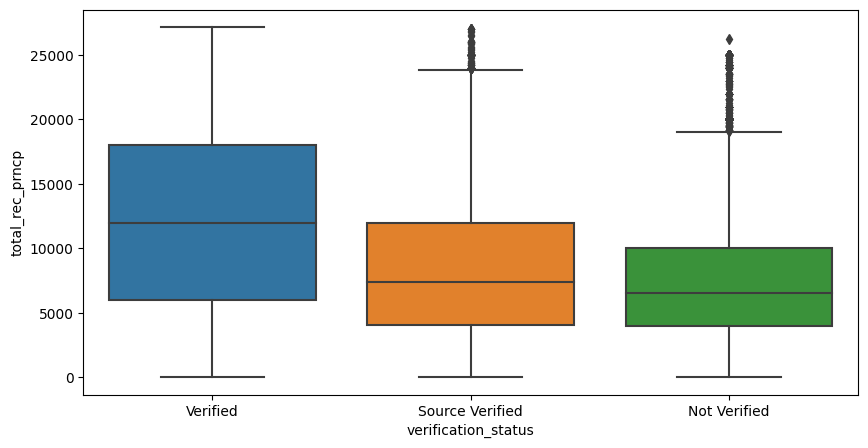

                    total_rec_prncp                                       \
                               mean  min       max <lambda_0> <lambda_1>   
verification_status                                                        
Not Verified            7603.262541  0.0  35000.00     4000.0     6500.0   
Source Verified         8830.905368  0.0  35000.01     4200.0     7500.0   
Verified               13436.909786  0.0  35000.02     6400.0    12000.0   

                                
                    <lambda_2>  
verification_status             
Not Verified           10000.0  
Source Verified        12000.0  
Verified               20000.0  
--------------------------------------------------------------------------------
field =  total_rec_prncp     Category =  purpose 



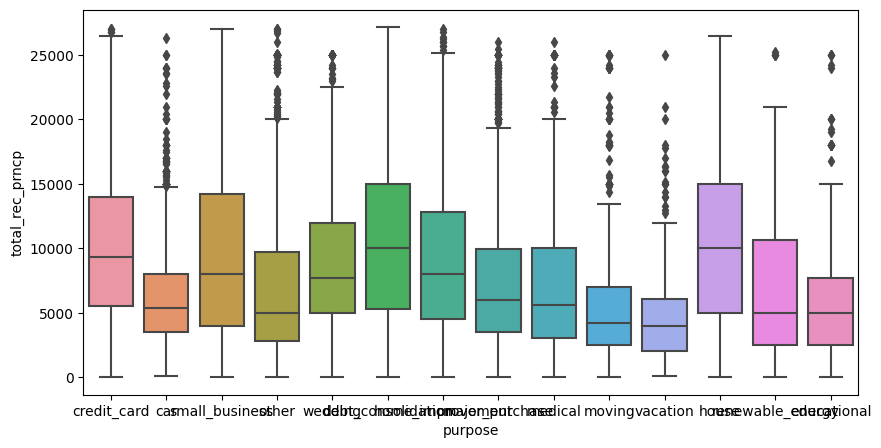

                   total_rec_prncp                                         \
                              mean    min       max <lambda_0> <lambda_1>   
purpose                                                                     
car                    6261.856682  82.02  30000.00     3500.0    5425.00   
credit_card           10572.552425   0.00  35000.00     5600.0    9600.00   
debt_consolidation    11035.478795   0.00  35000.02     5500.0   10000.00   
educational            5926.176031   0.00  25000.00     2500.0    5000.00   
home_improvement      10252.379167   0.00  35000.00     4800.0    8000.00   
house                 11350.802992   0.00  35000.01     5000.0   10000.00   
major_purchase         7358.155130   0.00  35000.00     3500.0    6000.00   
medical                7169.735570   0.00  35000.00     3000.0    5600.00   
moving                 5884.178113  21.21  35000.00     2500.0    4200.00   
other                  7009.007007   0.00  35000.02     2800.0    5000.00   

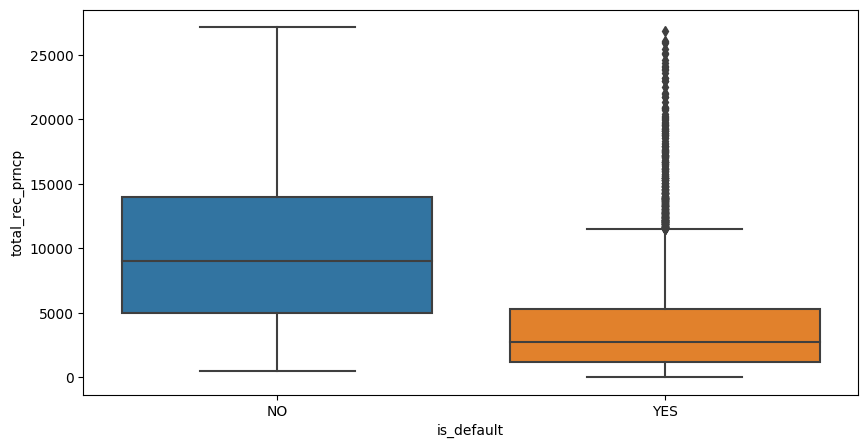

           total_rec_prncp                                                  
                      mean    min       max <lambda_0> <lambda_1> <lambda_2>
is_default                                                                  
NO            10755.034453  500.0  35000.02    5300.00    9600.00   14999.99
YES            3967.177947    0.0  31115.81    1205.78    2729.59    5341.13
--------------------------------------------------------------------------------
field =  revol_util     Category =  term 



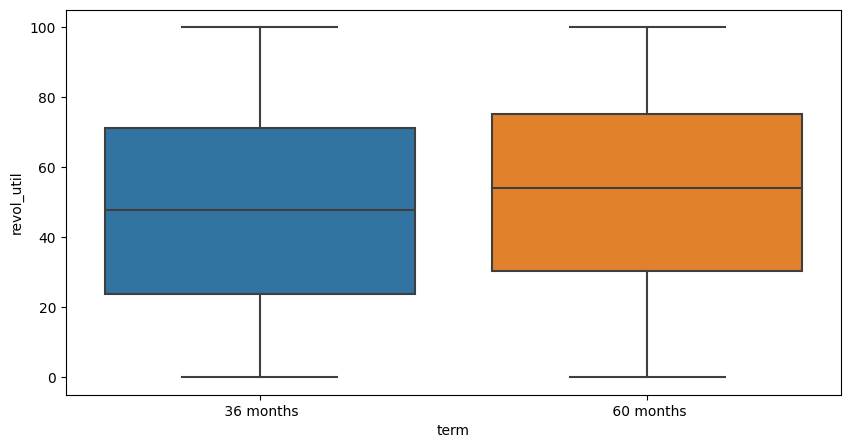

           revol_util                                            
                 mean  min   max <lambda_0> <lambda_1> <lambda_2>
term                                                             
 36 months  47.635949  0.0  99.9     23.800       47.7       71.2
 60 months  52.104758  0.0  99.9     30.425       53.9       75.1
--------------------------------------------------------------------------------
field =  revol_util     Category =  grade 



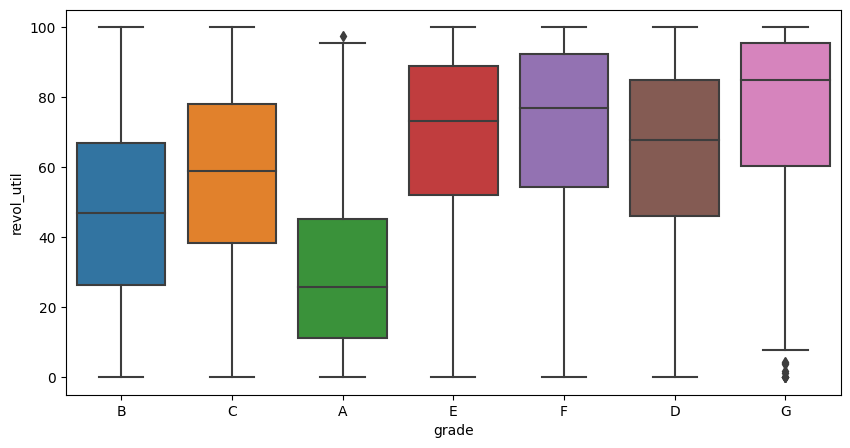

      revol_util                                            
            mean  min   max <lambda_0> <lambda_1> <lambda_2>
grade                                                       
A      29.838236  0.0  97.5     11.200      25.80      45.10
B      46.376830  0.0  99.9     26.400      46.80      66.80
C      56.537782  0.0  99.9     38.200      59.00      78.00
D      62.971648  0.0  99.9     46.000      67.70      84.80
E      67.741413  0.0  99.9     52.000      73.10      88.85
F      70.011601  0.0  99.9     54.300      76.80      92.30
G      75.384713  0.0  99.9     60.225      84.75      95.40
--------------------------------------------------------------------------------
field =  revol_util     Category =  home_ownership 



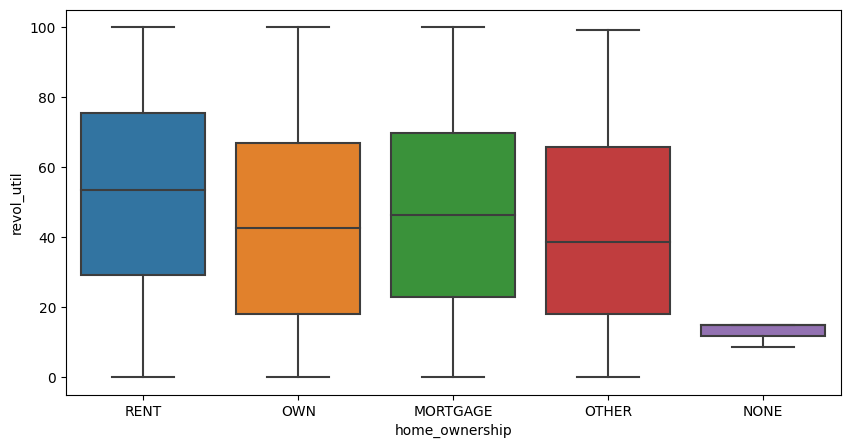

               revol_util                                            
                     mean  min   max <lambda_0> <lambda_1> <lambda_2>
home_ownership                                                       
MORTGAGE        46.654250  0.0  99.9     23.000      46.40     69.800
NONE            12.833333  8.7  14.9     11.800      14.90     14.900
OTHER           43.271875  0.0  99.1     17.875      38.65     65.625
OWN             43.711772  0.0  99.9     18.100      42.60     66.700
RENT            51.731920  0.0  99.9     29.100      53.50     75.400
--------------------------------------------------------------------------------
field =  revol_util     Category =  verification_status 



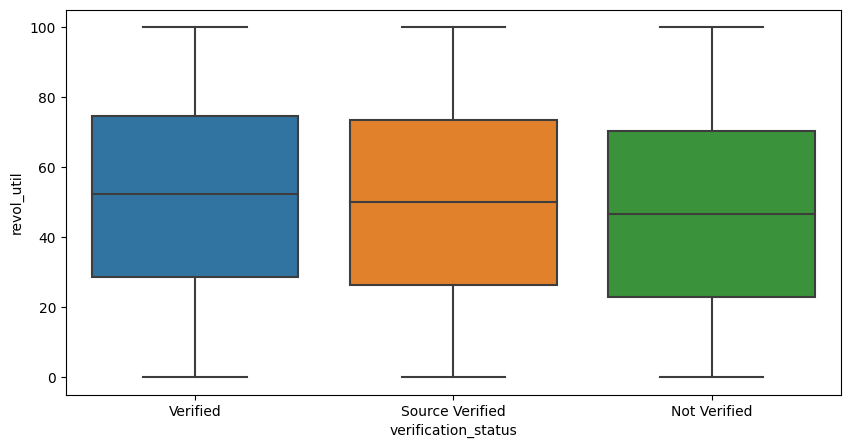

                    revol_util                                            
                          mean  min   max <lambda_0> <lambda_1> <lambda_2>
verification_status                                                       
Not Verified         46.821331  0.0  99.9      23.00       46.6     70.100
Source Verified      49.545660  0.0  99.9      26.30       50.1     73.325
Verified             50.929882  0.0  99.9      28.45       52.2     74.400
--------------------------------------------------------------------------------
field =  revol_util     Category =  purpose 



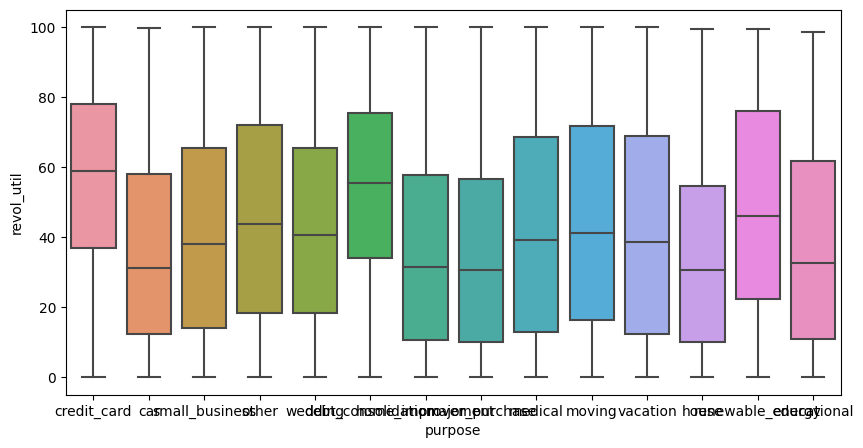

                   revol_util                                            
                         mean  min   max <lambda_0> <lambda_1> <lambda_2>
purpose                                                                  
car                 36.492230  0.0  99.7     12.200       31.1     58.000
credit_card         56.585037  0.0  99.9     36.900       58.8     77.900
debt_consolidation  54.071235  0.0  99.9     33.900       55.3     75.400
educational         38.649379  0.0  98.4     10.750       32.6     61.675
home_improvement    36.453029  0.0  99.9     10.450       31.4     57.800
house               35.193176  0.0  99.4     10.100       30.5     54.600
major_purchase      35.613847  0.0  99.9     10.100       30.6     56.500
medical             42.358799  0.0  99.9     12.950       39.1     68.500
moving              44.500516  0.0  99.8     16.300       41.2     71.800
other               45.479485  0.0  99.9     18.175       43.7     72.000
renewable_energy    47.226214  0.0  99

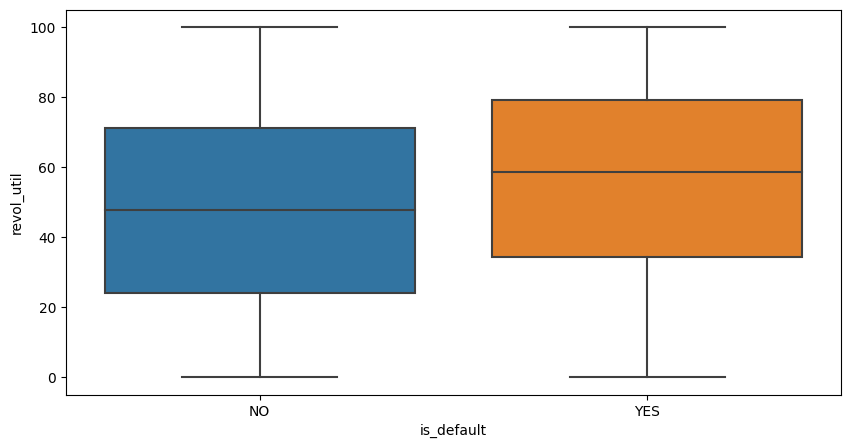

           revol_util                                            
                 mean  min   max <lambda_0> <lambda_1> <lambda_2>
is_default                                                       
NO           47.72169  0.0  99.9       24.1       47.8       71.0
YES          55.57211  0.0  99.9       34.4       58.4       79.0
--------------------------------------------------------------------------------
field =  total_acc     Category =  term 



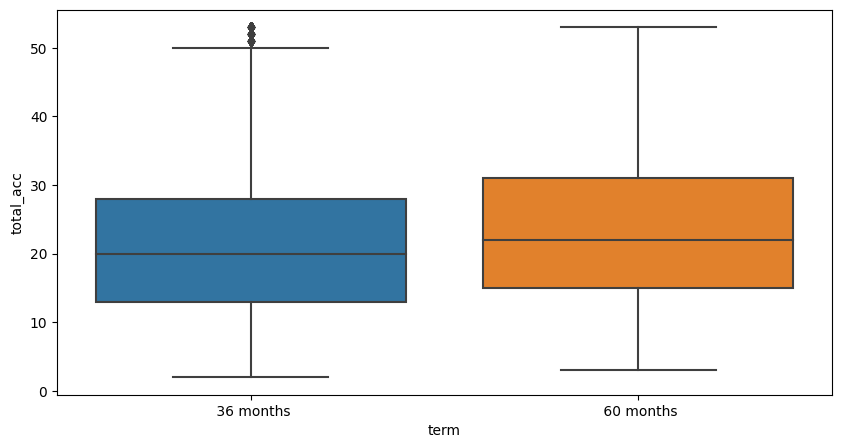

            total_acc                                         
                 mean min max <lambda_0> <lambda_1> <lambda_2>
term                                                          
 36 months  21.425419   2  90       13.0       20.0       28.0
 60 months  23.906224   3  87       15.0       22.0       31.0
--------------------------------------------------------------------------------
field =  total_acc     Category =  grade 



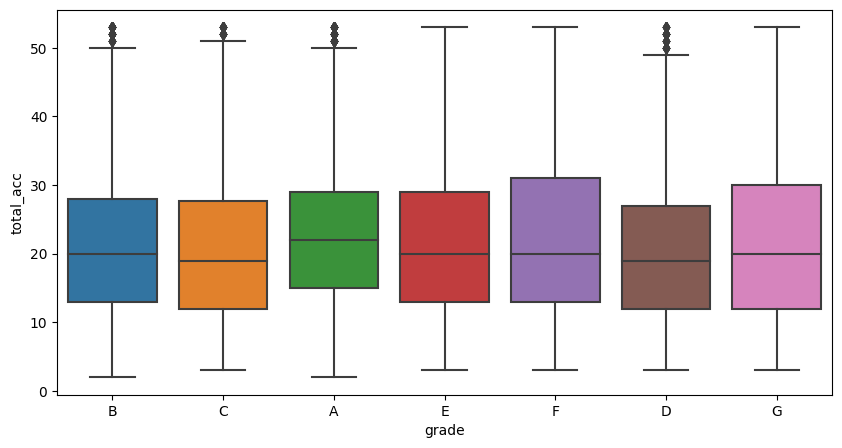

       total_acc                                         
            mean min max <lambda_0> <lambda_1> <lambda_2>
grade                                                    
A      23.460486   2  79       15.0       22.0       30.0
B      21.905657   2  90       13.0       20.0       28.0
C      21.107557   3  87       12.0       19.0       28.0
D      20.884304   3  80       12.0       19.0       28.0
E      22.237509   3  74       13.0       20.0       30.0
F      23.710200   3  81       13.0       21.0       32.0
G      23.936709   3  78       12.0       21.0       31.0
--------------------------------------------------------------------------------
field =  total_acc     Category =  home_ownership 



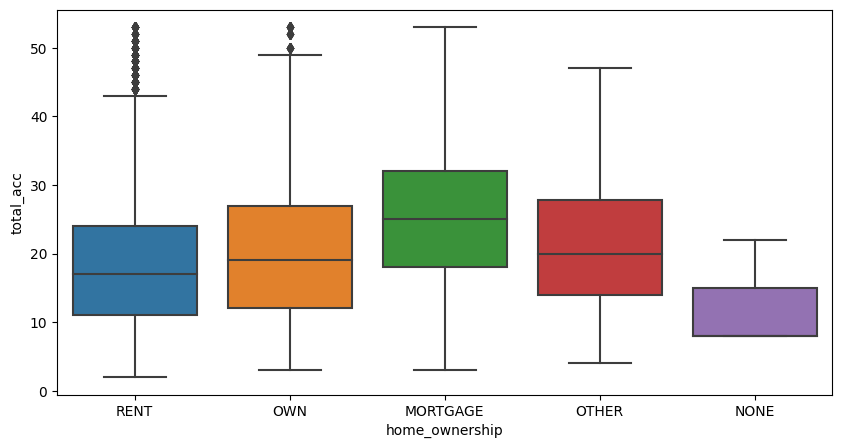

                total_acc                                         
                     mean min max <lambda_0> <lambda_1> <lambda_2>
home_ownership                                                    
MORTGAGE        26.254318   3  87       18.0       25.0      33.00
NONE            12.666667   8  22        8.0        8.0      15.00
OTHER           21.683673   4  47       14.0       20.0      27.75
OWN             20.824068   3  75       12.0       19.0      27.00
RENT            18.404889   2  90       11.0       17.0      24.00
--------------------------------------------------------------------------------
field =  total_acc     Category =  verification_status 



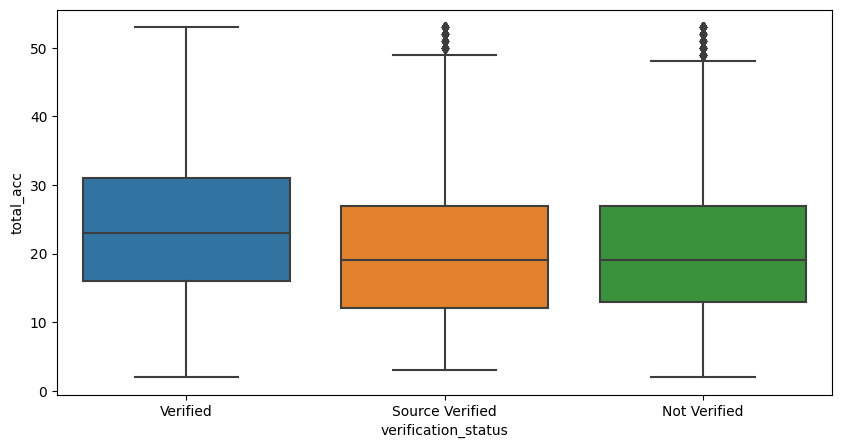

                     total_acc                                         
                          mean min max <lambda_0> <lambda_1> <lambda_2>
verification_status                                                    
Not Verified         21.093552   2  90       13.0       19.0       27.0
Source Verified      20.854311   3  87       12.0       19.0       27.0
Verified             24.366149   2  77       16.0       23.0       32.0
--------------------------------------------------------------------------------
field =  total_acc     Category =  purpose 



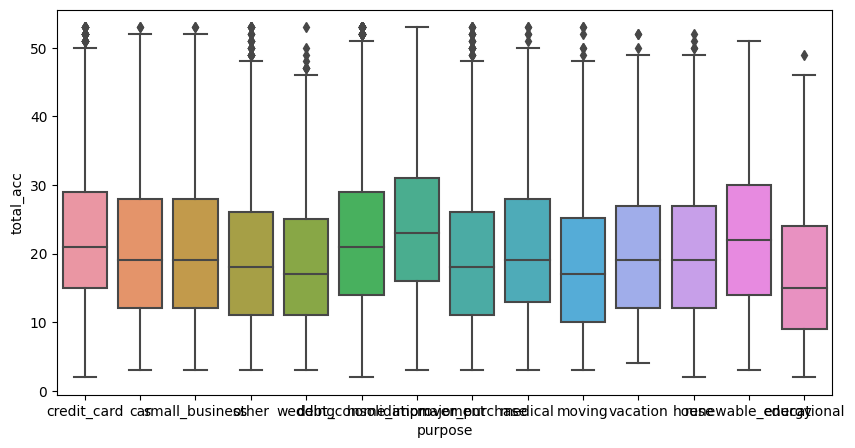

                    total_acc                                         
                         mean min max <lambda_0> <lambda_1> <lambda_2>
purpose                                                               
car                 20.708199   3  67       12.0       19.0       28.0
credit_card         22.984405   2  80       15.0       21.0       30.0
debt_consolidation  22.835202   2  90       14.0       21.0       29.0
educational         18.513846   2  63        9.0       16.0       25.0
home_improvement    24.159946   3  77       16.0       23.0       31.0
house               21.236220   2  62       12.0       19.0       27.0
major_purchase      19.904435   3  81       11.0       18.0       26.0
medical             21.613276   3  63       13.0       19.0       28.0
moving              18.830189   3  63       10.0       17.0       26.0
other               19.883797   3  76       11.0       18.0       27.0
renewable_energy    23.097087   3  63       14.0       22.0       30.5
small_

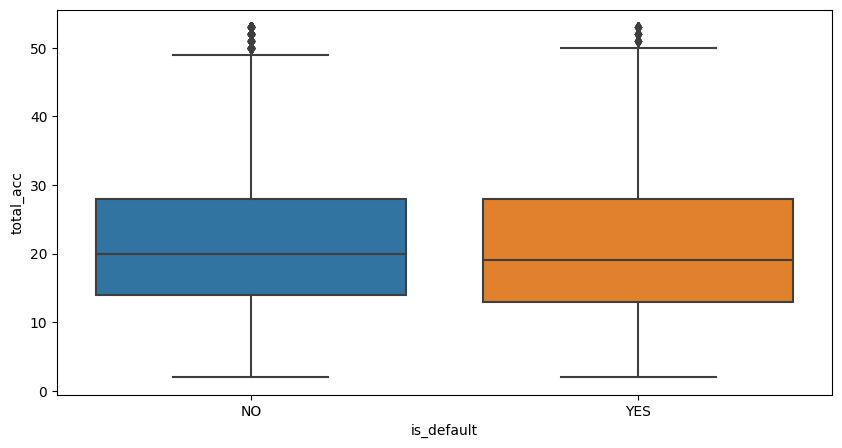

            total_acc                                         
                 mean min max <lambda_0> <lambda_1> <lambda_2>
is_default                                                    
NO          22.197976   2  90       14.0       21.0       29.0
YES         21.427581   2  74       13.0       20.0       28.0
--------------------------------------------------------------------------------
field =  open_acc     Category =  term 



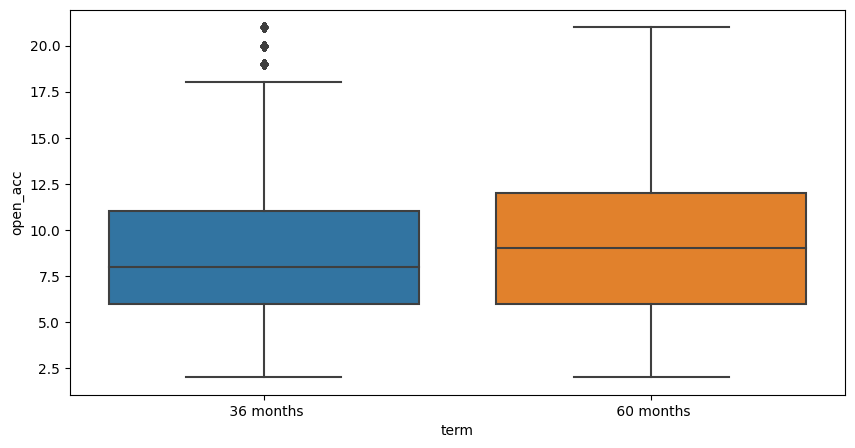

            open_acc                                         
                mean min max <lambda_0> <lambda_1> <lambda_2>
term                                                         
 36 months  9.159438   2  44        6.0        8.0       12.0
 60 months  9.664156   2  36        6.0        9.0       12.0
--------------------------------------------------------------------------------
field =  open_acc     Category =  grade 



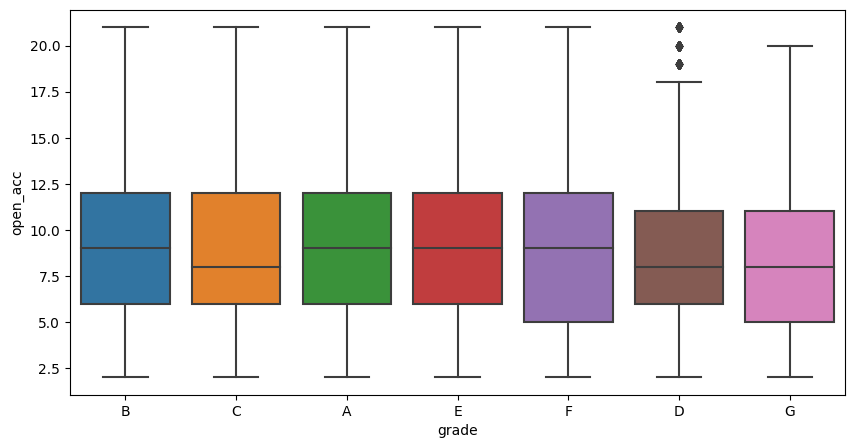

        open_acc                                         
            mean min max <lambda_0> <lambda_1> <lambda_2>
grade                                                    
A       9.437184   2  42        6.0        9.0       12.0
B       9.179118   2  32        6.0        9.0       12.0
C       9.156582   2  35        6.0        8.0       12.0
D       9.127002   2  30        6.0        8.0       12.0
E       9.519353   2  36        6.0        9.0       12.0
F      10.133460   2  39        6.0        9.0       13.0
G      10.658228   2  44        5.0        9.0       13.0
--------------------------------------------------------------------------------
field =  open_acc     Category =  home_ownership 



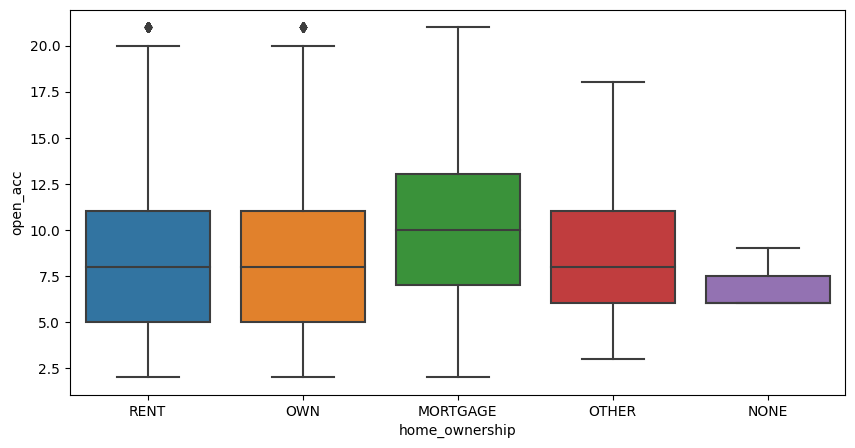

                 open_acc                                         
                     mean min max <lambda_0> <lambda_1> <lambda_2>
home_ownership                                                    
MORTGAGE        10.291806   2  42        7.0       10.0       13.0
NONE             7.000000   6   9        6.0        6.0        7.5
OTHER            8.877551   3  24        6.0        8.0       11.0
OWN              8.971877   2  44        6.0        8.0       12.0
RENT             8.417165   2  34        5.0        8.0       11.0
--------------------------------------------------------------------------------
field =  open_acc     Category =  verification_status 



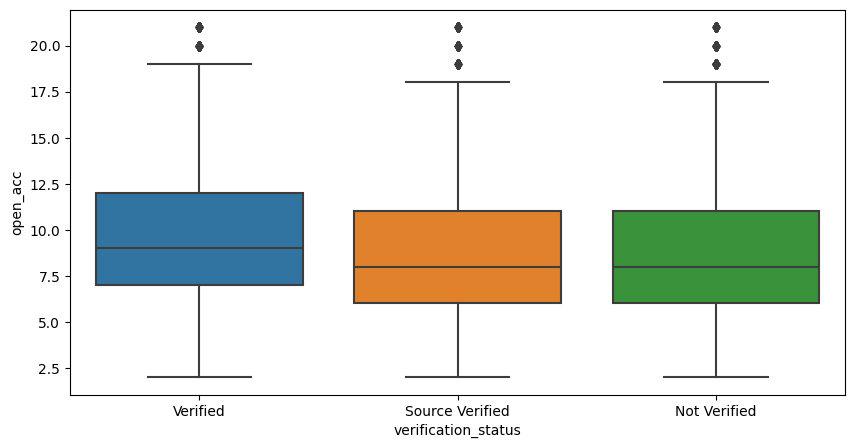

                     open_acc                                         
                         mean min max <lambda_0> <lambda_1> <lambda_2>
verification_status                                                   
Not Verified         9.014065   2  44        6.0        8.0       11.0
Source Verified      8.971263   2  36        6.0        8.0       11.0
Verified             9.916699   2  34        7.0        9.0       12.0
--------------------------------------------------------------------------------
field =  open_acc     Category =  purpose 



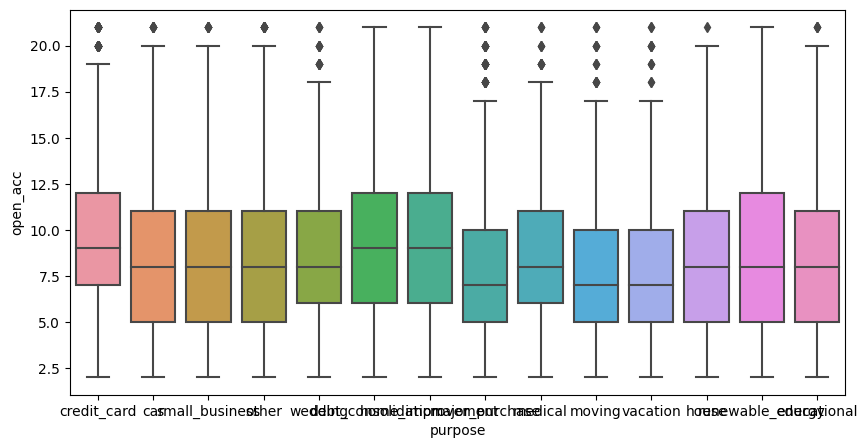

                    open_acc                                         
                        mean min max <lambda_0> <lambda_1> <lambda_2>
purpose                                                              
car                 8.610717   2  28        5.0        8.0       11.0
credit_card         9.818713   2  39        7.0        9.0       12.0
debt_consolidation  9.676520   2  44        7.0        9.0       12.0
educational         8.913846   2  35        5.0        8.0       12.0
home_improvement    9.446909   2  35        6.0        9.0       12.0
house               8.580052   2  24        5.0        8.0       11.0
major_purchase      8.231367   2  35        5.0        7.0       10.0
medical             9.030303   2  29        6.0        8.0       11.0
moving              8.169811   2  33        5.0        7.0       10.0
other               8.402204   2  42        5.0        8.0       11.0
renewable_energy    9.165049   2  25        5.0        8.0       12.0
small_business      

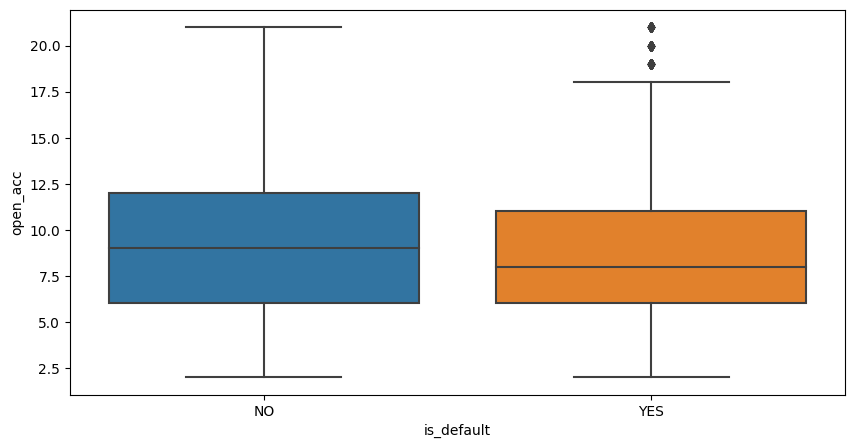

            open_acc                                         
                mean min max <lambda_0> <lambda_1> <lambda_2>
is_default                                                   
NO          9.313611   2  44        6.0        9.0       12.0
YES         9.178070   2  38        6.0        8.0       12.0
--------------------------------------------------------------------------------


In [53]:
def remove_outliers(df: pd.DataFrame, field: str) -> pd.DataFrame:
    Q1 = df[field].quantile(0.25)
    Q3 = df[field].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    return df[(df[field] >= lower) & (df[field] <= upper)]

categories = ['term',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'is_default']

quantitative = ['loan_amnt',
 'int_rate',
 'total_rec_prncp',
 'revol_util',
 'total_acc',
 'open_acc']

for field in quantitative:
    for category in categories:
        print("field = ", field, "    Category = ", category,'\n')
        clean_df = remove_outliers(df_final, field)
        plt.figure(figsize=(10, 5))
        sns.boxplot(y=field, x=category, data=clean_df)
        plt.show()
        df_segment = df_final.groupby(category)
        print(df_segment.agg({field : ['mean','min','max', lambda x:x.quantile(0.25), 
                                             lambda x:x.quantile(0.5), lambda x:x.quantile(0.75)]}))
        print("-" * 80)


<span style="color:green">Inferences - Segmented Univarite Analysis:  </span>
- Loan_amount and Term : Loan amount is higher for 60 months tenure loans than that of 36 months tenure loans  
- Loan_amount and Grade : Loan amount is higher for the loans with grades G, F, E ampared to other grade loans  
- Loan_ amount and Varification status : Loan amount is higher for the Verified loan status than Not verified loan status   
- Int_rate and Term : Interest rate is high for 60 months tenure loans than 36 months tenure loans  
- Int_rate and Grade : Interest rates gradually increase for the loans with grades A, B, C, D, E, F, G. G grade loans have highest interest rates where as A grade loans have lowest interest rates.  
- total_rec_prncp and Term : Principal received till date is high for the 60 month tenure loans than 36 months loans  
- total_rec_prncp and Grades: Principal received till date is high for the G grade loans than any other grade loans  
- total_rec_prncp and is default : For defaulted loans, principal received till date is very less.  
- revol_util and grade: Revolving line utilization rate (the amount of credit the borrower is using relative to all available revolving credit) is lowest for grade A loans and it is highest for grade G loans  
- revol_util and is_default : Revolving line utilization rate is high for defaulters than non-defaulters.  


<span style="color:green">Inferences - Segmented Univariate Analysis on Default status:  </span>
- int_rate - Default loan has higher interest rate than non-default loans. On an average default loan interest rate is 13.88% (2% higher) where as for non default loan interest rate is 11.7%.   

- We can say that defaulter borrowers' annual income is less compared to non-defaulter borrowers'.  

- total_rec_prncp - We can clearly see that there is a hugh difference in principal received from defaulters and non-defaulters. Average principal received from non defaulters is around 10.7K where as from non- defaluters is only 4k. Which is almost 60% less principal received from defaulters compared to non-defaulters.   

- revol_util - Revolving line utilization rate is higher for the defaulters than non-defaulters. Loan given to higher amount of credit  borrower is using relative to all available revolving credit leads to loan default.
   
- open_acc - Number of open credit lines in defaulters credit file is less compared to non-defaulters. 


### Segmented Analysis on Timeseries

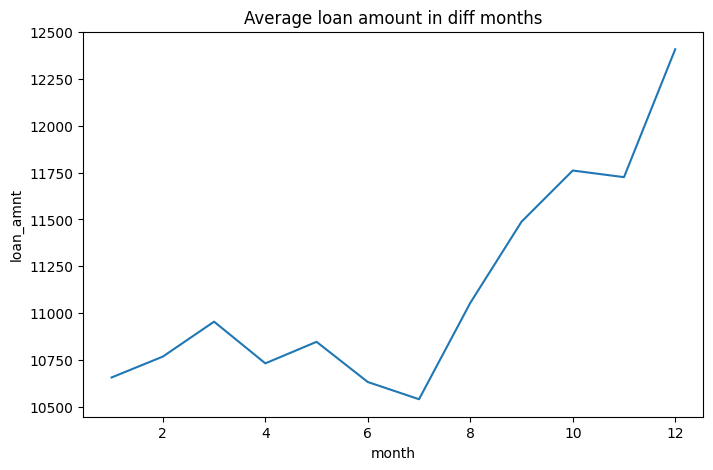

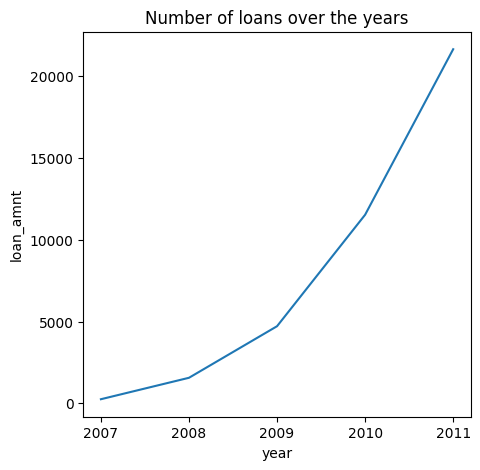

In [54]:
df_timeseries = df_final[['issue_d', 'loan_amnt']]
df_timeseries['issue_d'] = pd.to_datetime(df_timeseries['issue_d'])
df_timeseries['month'] = df_timeseries['issue_d'].dt.month
df_timeseries['year'] = df_timeseries['issue_d'].dt.year

#---------------------------------------------------------------

plt.figure(figsize=(8,5),facecolor='white',edgecolor='blue')
df_tmp = df_timeseries[["loan_amnt", 'month', 'year']]
df_tmp_agg_month = df_tmp.groupby(['month']).agg({"loan_amnt": "mean"}).reset_index()

sns.lineplot(df_tmp_agg_month[["loan_amnt", 'month']].sort_values(by='month'), 
             x = df_tmp_agg_month['month'], y = df_tmp_agg_month["loan_amnt"], markers='x')
plt.title("Average loan amount in diff months")
plt.show()

#---------------------------------------------------------------

plt.figure(figsize=(5,5),facecolor='white', edgecolor='blue')
df_tmp_agg_year = df_tmp.groupby(['year']).agg({"loan_amnt": "count"}).reset_index()

ax = sns.lineplot(df_tmp_agg_year[["loan_amnt", 'year']].sort_values(by='year'), 
             x = df_tmp_agg_year['year'], y = df_tmp_agg_year["loan_amnt"])
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.title("Number of loans over the years")
plt.show()


<span style="color:green">Inferences - Segmented Univariate Analysis on Default status on timeseries:  </span>
- Number of loan applicants are increasing over the period of time.
- Total borrowers in 2011 is highest i.e. 21K
- On an average loan amount given to the borrowers is high in 2nf half of the year compared to first half

# 5. Bivariate Analysis
---

## A. On Continuous/ Quantitative  Variables

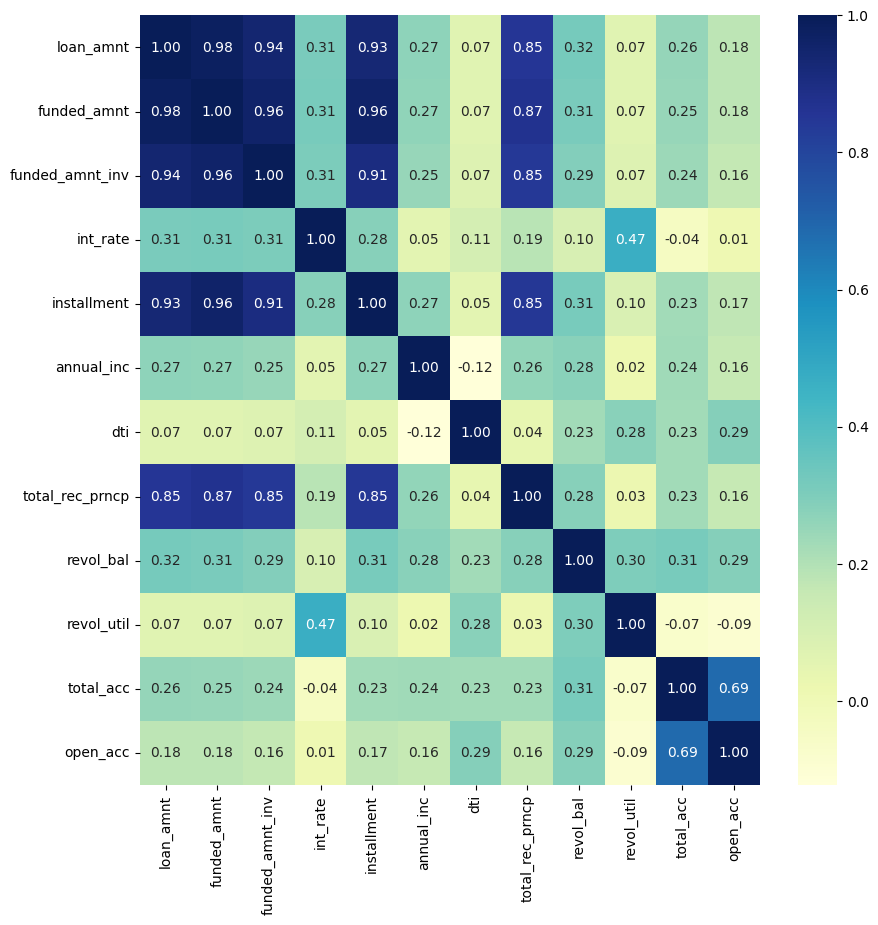

In [55]:
#sns.set()
plt.figure(figsize=(10, 10))  # Set the figure size
heatmap = sns.heatmap(df_final[['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'total_rec_prncp',
 'revol_bal',
 'revol_util',
 'total_acc',
 'open_acc']].corr(), fmt='0.2f', cmap="YlGnBu", annot=True)

plt.show()

<span style="color:green">Inferences - Bivariate Analysis on Continuous Variables:  </span>
- loan_amnt, funded_amnt, funded_amnt_inv = We can say there is a very high correlation between loan amount applied by the borrower and loan amount committed by the investor to the borrower. So whenever loan application of the borrower gets passed by company, then he gets almost full amount of the loan applied.
  
- loan_amnt, installment, total_rec_prncp - It is also obvious that monthly installment and loan amount are highly correlated. Higher the loan amount, higher is monthly installment and and higher is principal received  vice versa.
  
- total_acc, open_acc- Number open credit lines is also highly correlated with total number of credit lined in the borrower's credit file.  

- revol_util, int_rate - Revolving line utilization rate and interest rate are moderately correlated with each other. Higher the amount of credit the borrower is using, higher is the risk of loan repayment. Thats why higher is the interest rate, and vice-versa.



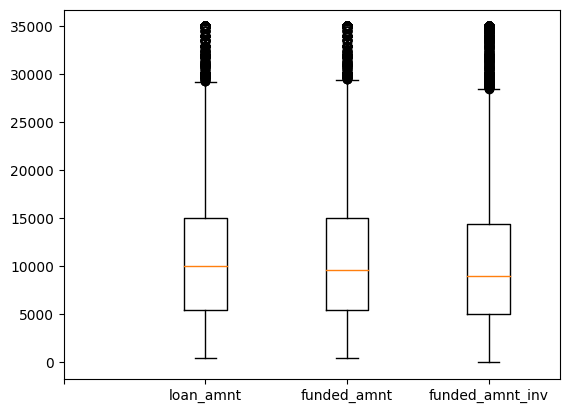

In [56]:
df_subset = df[['loan_amnt', 'funded_amnt','funded_amnt_inv']]
plt.boxplot(df_subset)
x_labels = ["","loan_amnt", "funded_amnt",'funded_amnt_inv']
plt.xticks(range(len(x_labels)), x_labels)
plt.show()

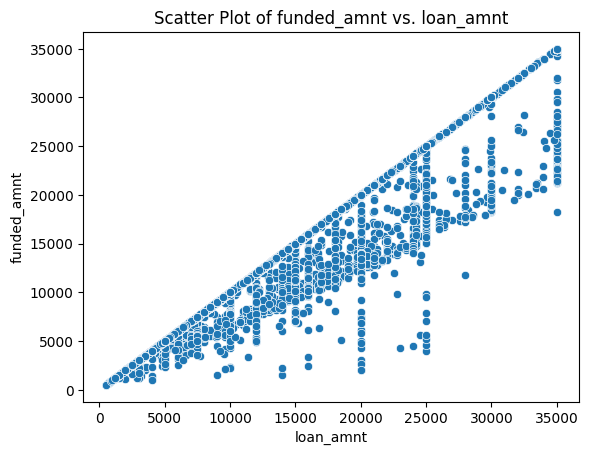

In [57]:
sns.scatterplot(data=df_final, x="loan_amnt", y="funded_amnt")

# Add labels and a title
plt.xlabel("loan_amnt")
plt.ylabel("funded_amnt")
plt.title("Scatter Plot of funded_amnt vs. loan_amnt")

# Show the plot
plt.show()

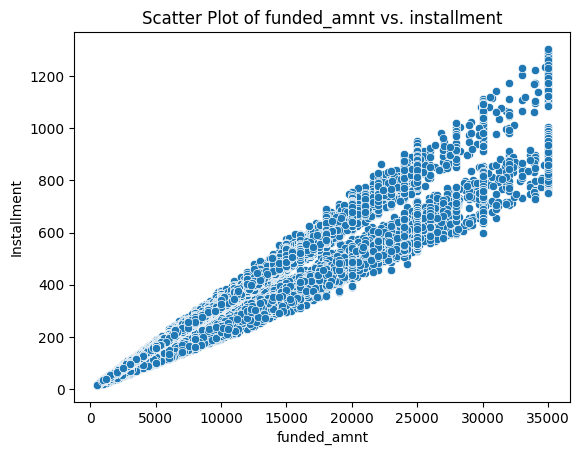

In [58]:
sns.scatterplot(data=df_final, x="funded_amnt", y="installment")

# Add labels and a title
plt.xlabel("funded_amnt")
plt.ylabel("Installment")
plt.title("Scatter Plot of funded_amnt vs. installment")

# Show the plot
plt.show()

<span style="color:green">Inferences - Correlation Between Loan Amount, Funded Amount, Installment:</span>  
 
- Funded amount by the company is always less than or equal to loan amount applied by borrower.  
- Funded amount by the company is highly correlated with monthly installment paid by the borrower.  
- There is a high correltion between loan amount, funded amount and installment



## B. On Categorical Variables

In [59]:
object_types_df = load_type_df(df_final, 'object')
categorical_variables = object_types_df[object_types_df["field"] != 'is_default']['field'].to_list()
categorical_variables

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'addr_state']


 % of Loans applications distributed in term and grade 



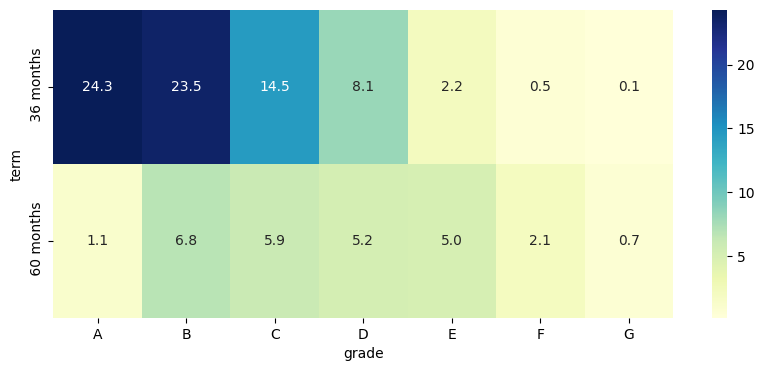


======= Impact of TERM and GRADE together on LOAN STATUS ========



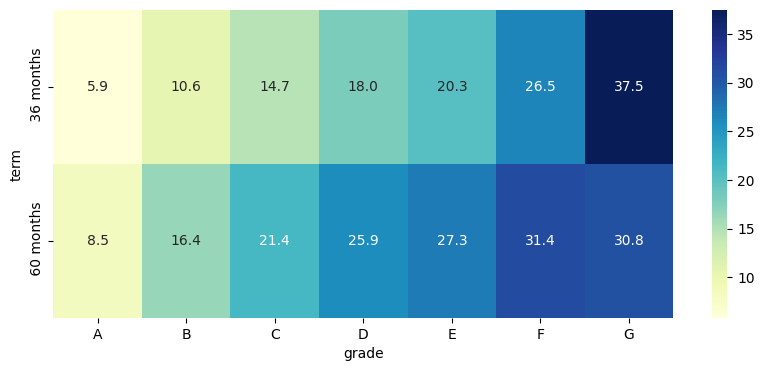

********************************************************************************

 % of Loans applications distributed in term and emp_length 



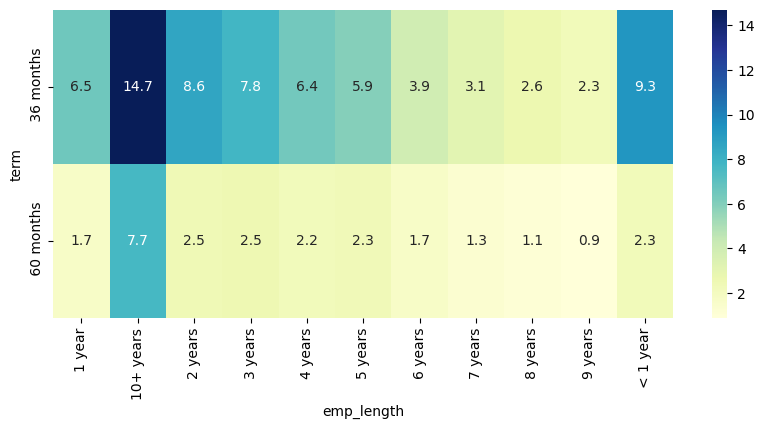


======= Impact of TERM and EMP_LENGTH together on LOAN STATUS ========



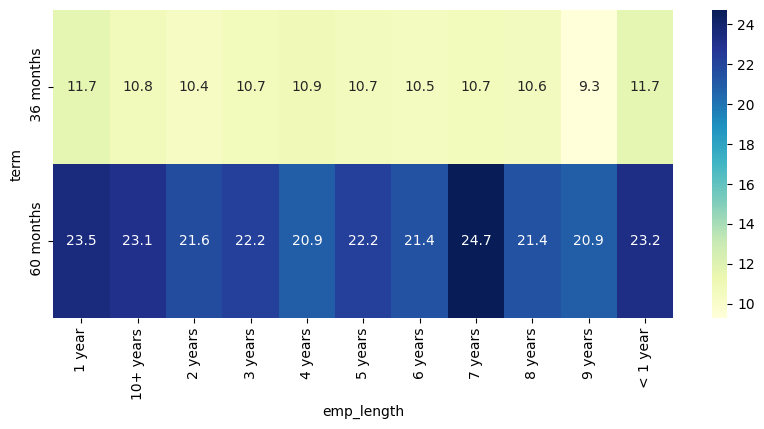

********************************************************************************

 % of Loans applications distributed in term and home_ownership 



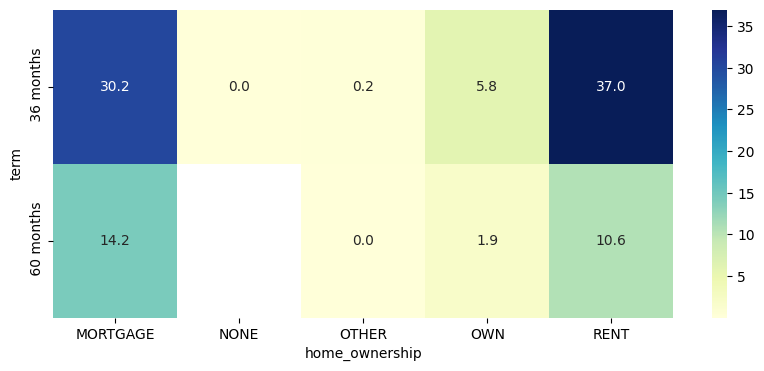


======= Impact of TERM and HOME_OWNERSHIP together on LOAN STATUS ========



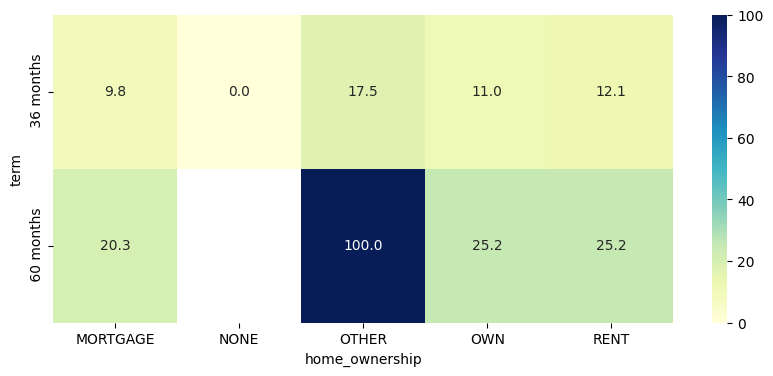

********************************************************************************

 % of Loans applications distributed in term and verification_status 



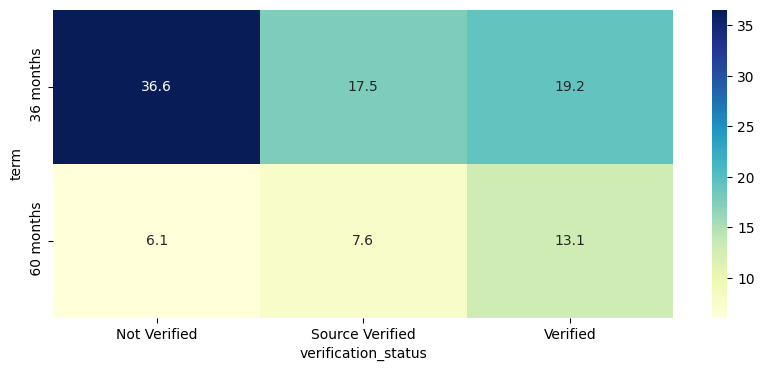


======= Impact of TERM and VERIFICATION_STATUS together on LOAN STATUS ========



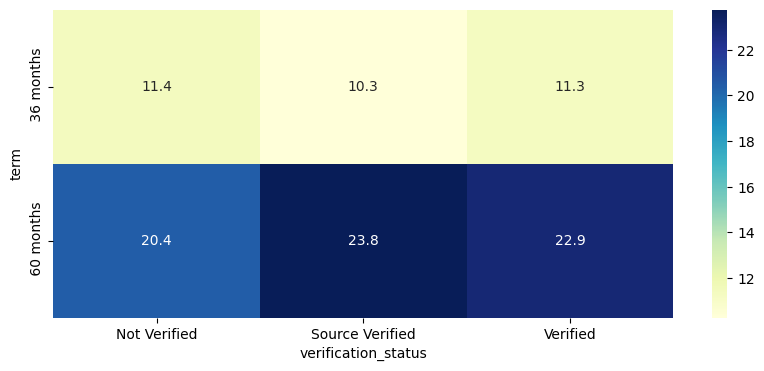

********************************************************************************

 % of Loans applications distributed in term and purpose 



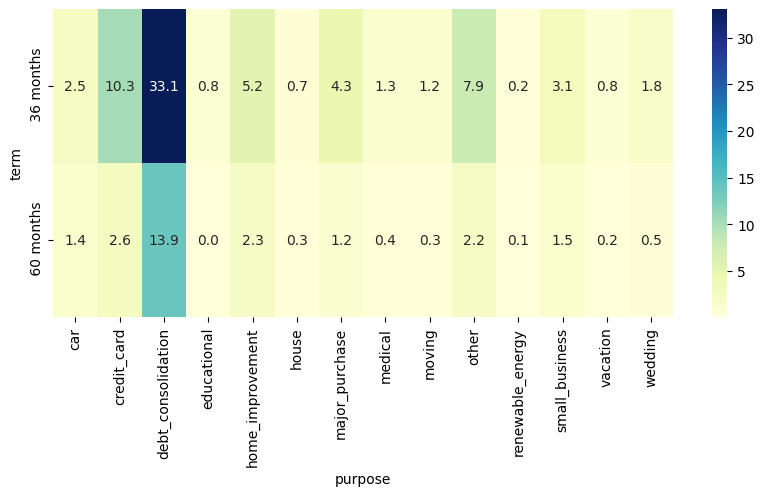


======= Impact of TERM and PURPOSE together on LOAN STATUS ========



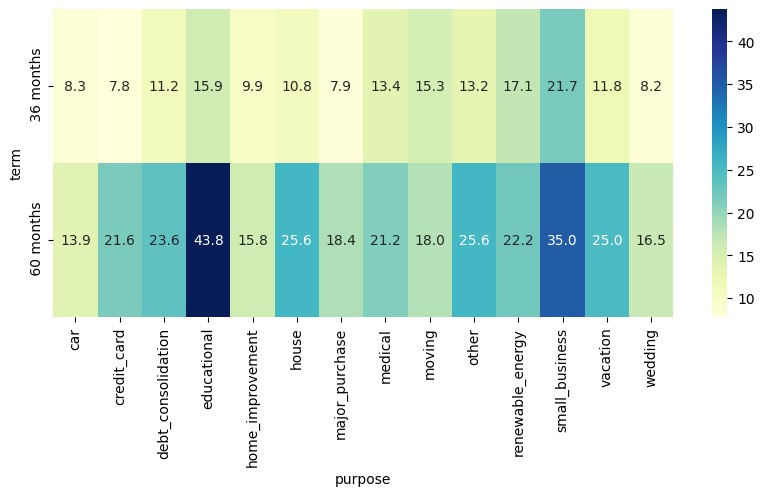

********************************************************************************

 % of Loans applications distributed in grade and emp_length 



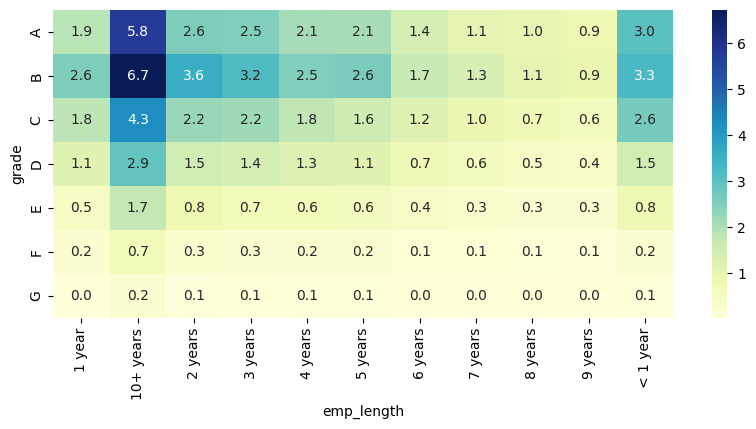


======= Impact of GRADE and EMP_LENGTH together on LOAN STATUS ========



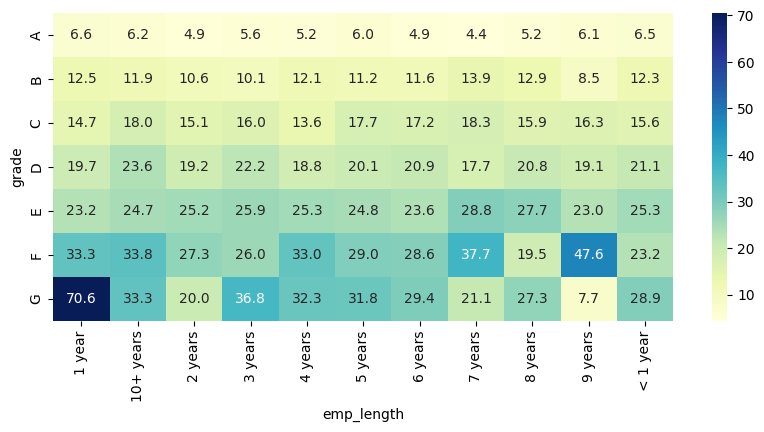

********************************************************************************

 % of Loans applications distributed in grade and home_ownership 



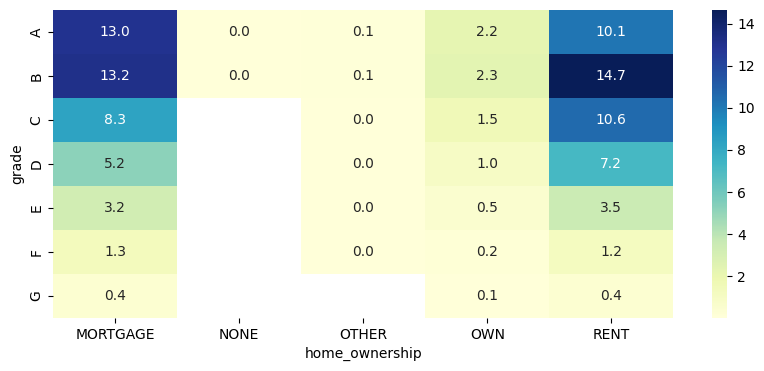


======= Impact of GRADE and HOME_OWNERSHIP together on LOAN STATUS ========



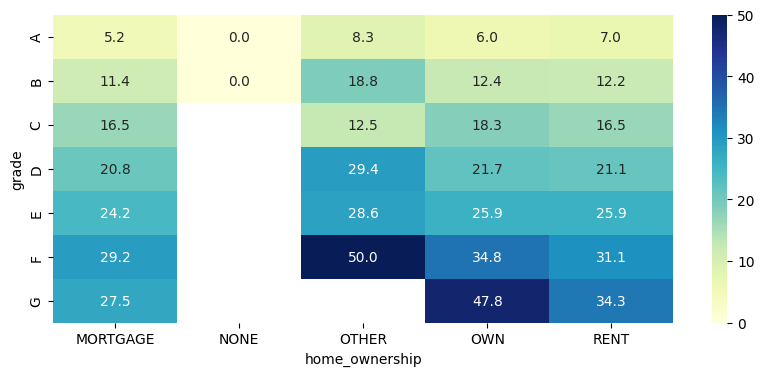

********************************************************************************

 % of Loans applications distributed in grade and verification_status 



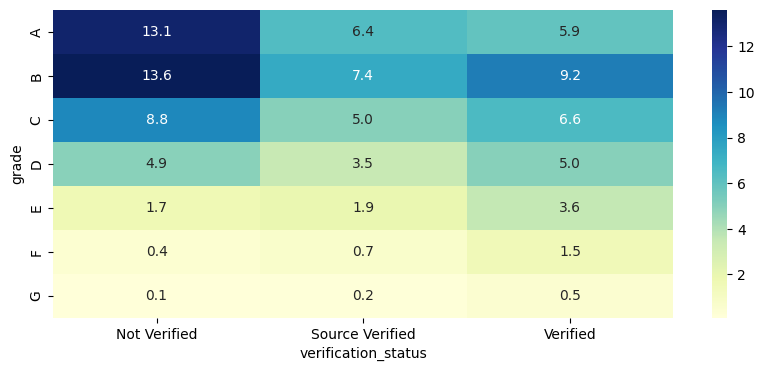


======= Impact of GRADE and VERIFICATION_STATUS together on LOAN STATUS ========



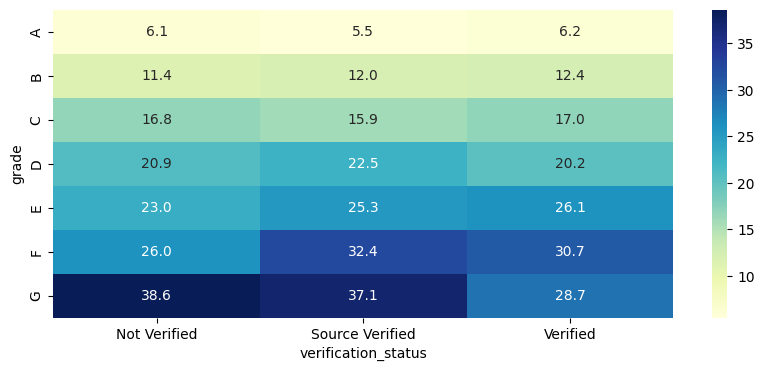

********************************************************************************

 % of Loans applications distributed in grade and purpose 



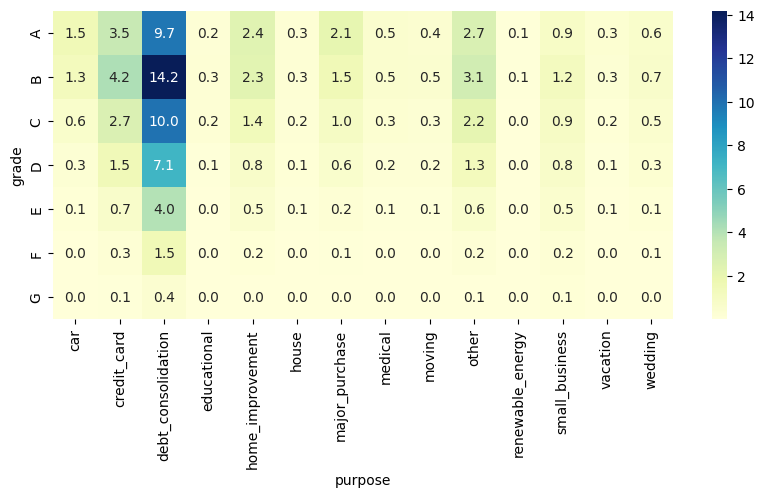


======= Impact of GRADE and PURPOSE together on LOAN STATUS ========



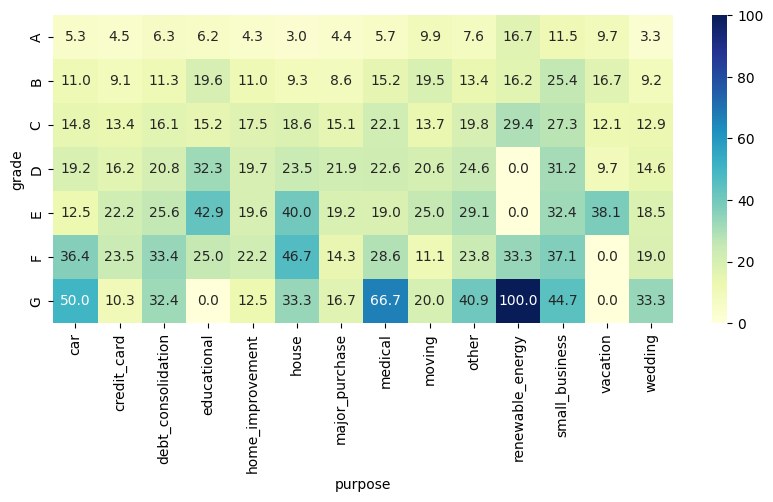

********************************************************************************

 % of Loans applications distributed in emp_length and home_ownership 



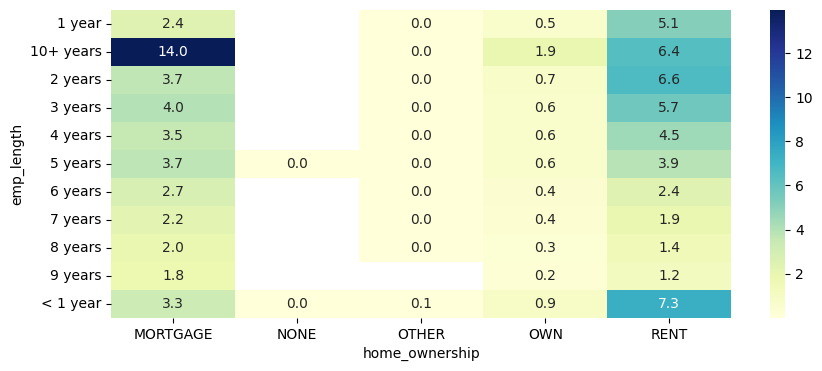


======= Impact of EMP_LENGTH and HOME_OWNERSHIP together on LOAN STATUS ========



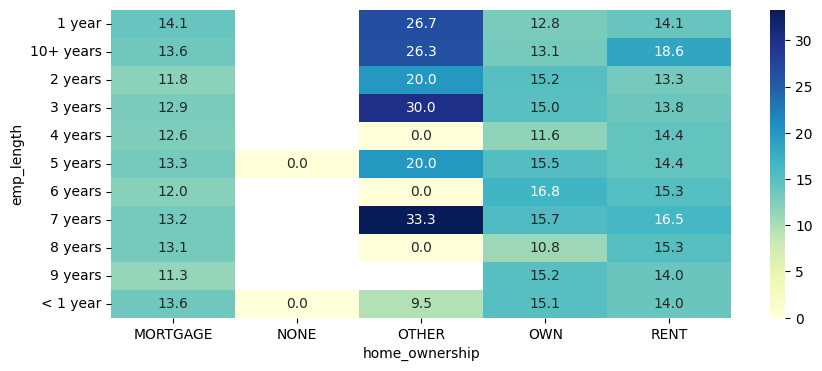

********************************************************************************

 % of Loans applications distributed in emp_length and verification_status 



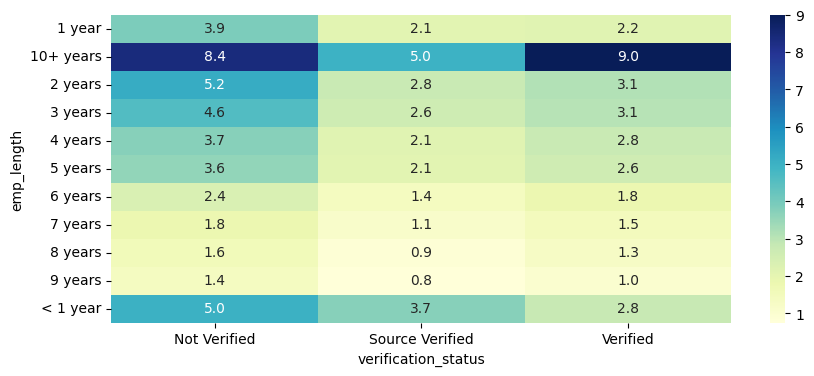


======= Impact of EMP_LENGTH and VERIFICATION_STATUS together on LOAN STATUS ========



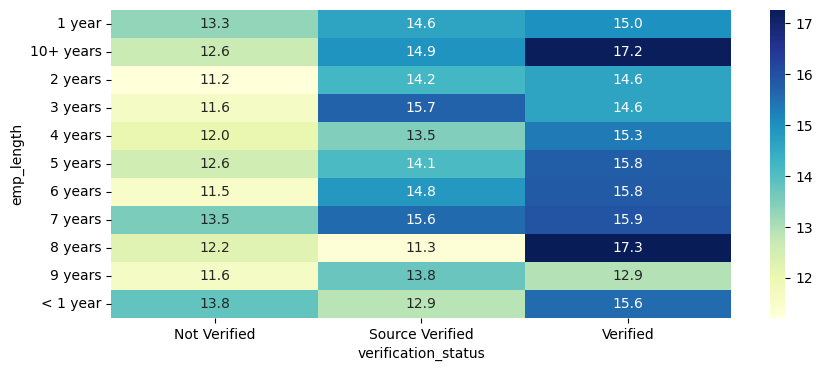

********************************************************************************

 % of Loans applications distributed in emp_length and purpose 



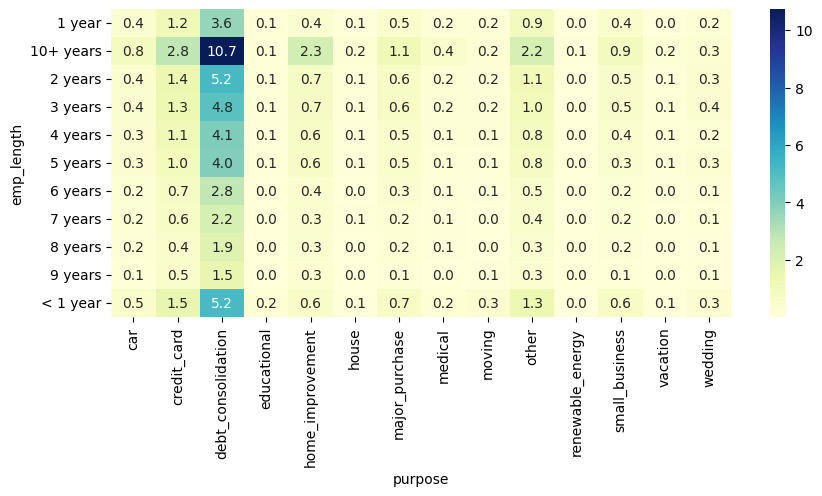


======= Impact of EMP_LENGTH and PURPOSE together on LOAN STATUS ========



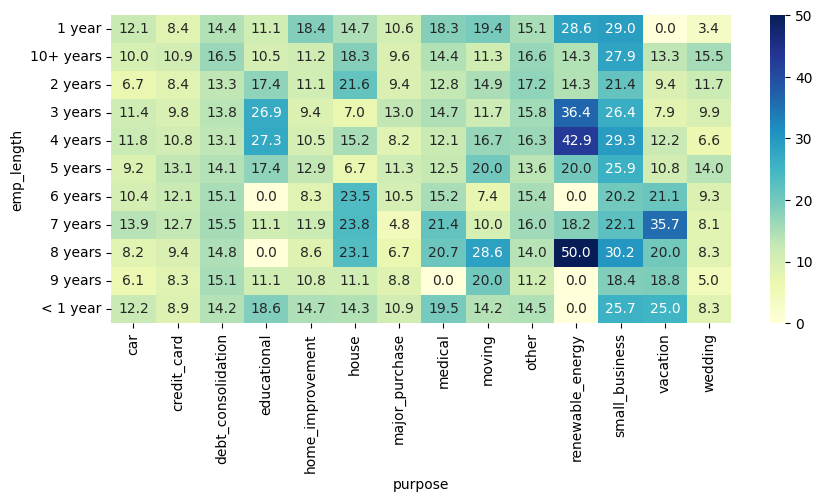

********************************************************************************

 % of Loans applications distributed in home_ownership and verification_status 



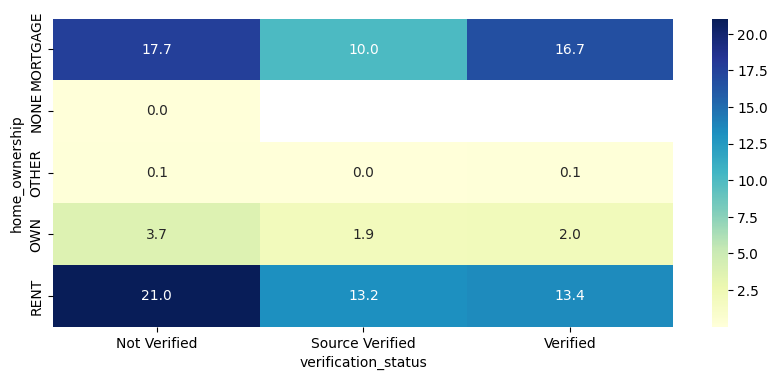


======= Impact of HOME_OWNERSHIP and VERIFICATION_STATUS together on LOAN STATUS ========



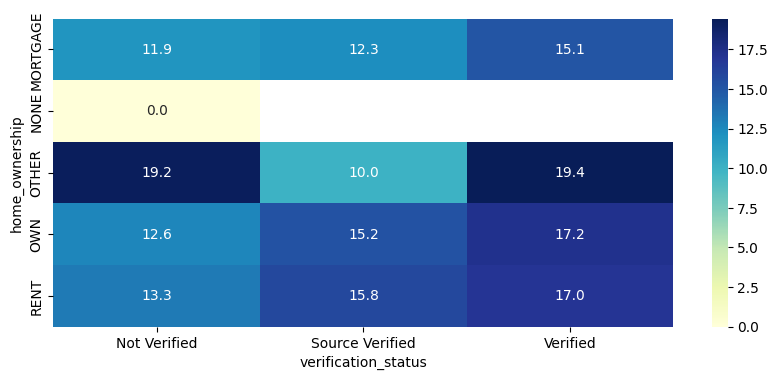

********************************************************************************

 % of Loans applications distributed in home_ownership and purpose 



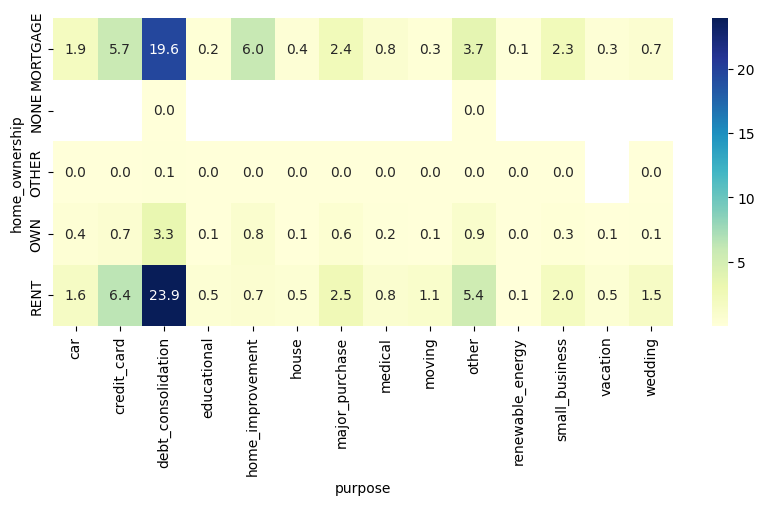


======= Impact of HOME_OWNERSHIP and PURPOSE together on LOAN STATUS ========



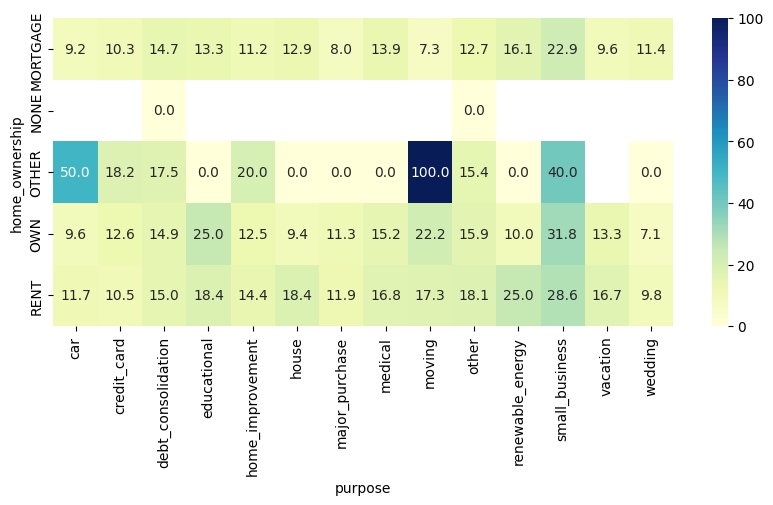

********************************************************************************

 % of Loans applications distributed in verification_status and purpose 



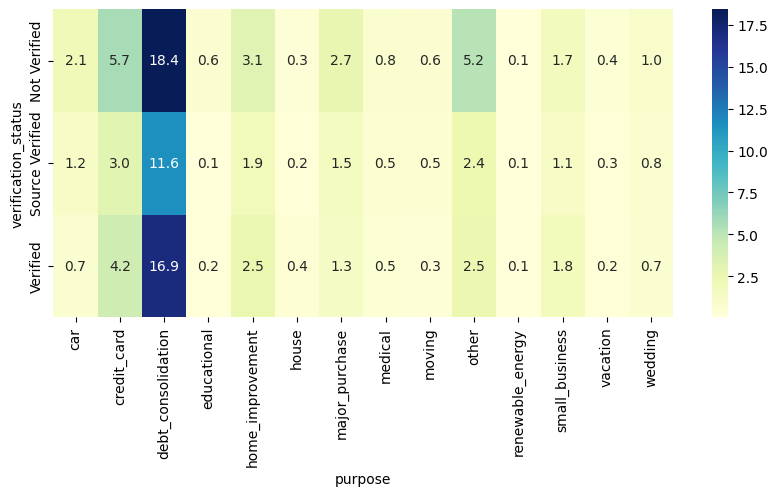


======= Impact of VERIFICATION_STATUS and PURPOSE together on LOAN STATUS ========



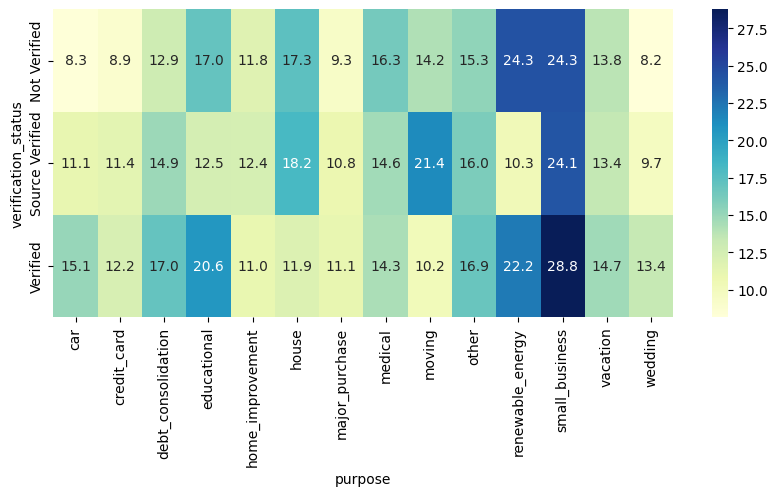

********************************************************************************


In [60]:
fields = ['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose']

for i in range(len(fields)):
    for j in range(i + 1, len(fields)):
        row = fields[i]
        column = fields[j]

        t = pd.pivot_table(
            df_final, 
            index=row, 
            columns=column, 
            values='loan_amnt', 
            aggfunc='count',
            ).apply(lambda x: x * 100/len(df_final))

        if len(t) == 0:
            continue

            
        print(f"\n % of Loans applications distributed in {row} and {column} \n")

        plt.figure(figsize=(10, 4))
        sns.heatmap(t, cmap='YlGnBu',annot=True, fmt='0.1f')
        plt.show()
        
        t = pd.pivot_table(
            df_final, 
            index=row, 
            columns=column, 
            values='default_status', 
            aggfunc='mean',
            ).apply(lambda x: x * 100)

        if len(t) == 0:
            continue

        print(f"\n======= Impact of {row.upper()} and {column.upper()} together on LOAN STATUS ========\n")

        #sns.set(rc={'figure.figsize': (10, 4)})
        plt.figure(figsize=(10, 4))
        sns.heatmap(t, cmap='YlGnBu',annot=True, fmt='0.1f')
        plt.show()

        
        
        print("*" * 80)
   

<span style="color:green">Inferences - Bivariate Analysis on Categorical Variables:  </span>

- term & Grade - G grade loans with 36 month tenure has highest chance of default (37%) where as A grade loans with 36 month tenure has lowest chance of default(5.9%).  

- term & Pupose - Education loan and small business purpose loan with 60 month tenure is very likey to get default (43.8% and 35% resp).  

- Grade and emp_length - G grade loans with 1 year of employment length has very high chance of getting defalt i.e. 70.6%. F grade loans with 9 years of employment length has second highest chance of getting defalt i.e. 47.6%.  

